In [63]:
import pywt
import os
LOAD = False         # True = load previously saved model from disk?  False = (re)train the model
SAVE = "\_TFT_model_02.pth.tar"   # file name to save the model under

EPOCHS = 200
INLEN = 16          # input size
HIDDEN = 32         # hidden layers    
LSTMLAYERS = 2      # recurrent layers

ATTH = 2            # attention heads
BATCH = 64          # batch size
LEARN = 1e-3        # learning rate
DROPOUT = 0.1       # dropout rate
VALWAIT = 1         # epochs to wait before evaluating the loss on the test/validation set
N_FC = 2            # output size

RAND = 42           # random seed
N_SAMPLES = 100     # number of times a prediction is sampled from a probabilistic model
N_JOBS = -1          # parallel processors to use;  -1 = all processors

# default quantiles for QuantileRegression
QUANTILES = [0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99]

SPLIT = 0.9         # train/test %

FIGSIZE = (9, 6)


qL1, qL2 = 0.01, 0.10        # percentiles of predictions: lower bounds
qU1, qU2 = 1-qL1, 1-qL2,     # upper bounds derived from lower bounds
label_q1 = f'{int(qU1 * 100)} / {int(qL1 * 100)} percentile band'
label_q2 = f'{int(qU2 * 100)} / {int(qL2 * 100)} percentile band'

mpath = os.path.abspath(os.getcwd()) + SAVE     # path and file name to save the model

In [64]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import missingno as mno

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TransformerModel, NBEATSModel, TFTModel, NLinearModel, DLinearModel
from darts.metrics import mape, rmse, smape
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.2f}'.format

In [65]:
import pandas as pd
xls = pd.ExcelFile('./data.xlsx')
df_radon={}
for key in xls.sheet_names[2:]:
    df_radon[key] = pd.read_excel(xls, key)

In [66]:
for key in df_radon:
    df_radon[key]['SyncDate'] = pd.to_datetime(df_radon[key]['SyncDate'])
    df_radon[key].sort_values(by='SyncDate', ascending=True, inplace=True)
    df_radon[key]['SyncDate'] = df_radon[key]['SyncDate'].dt.floor('H')
    df_radon[key] = df_radon[key].resample('H', on = 'SyncDate').mean()
    df_radon[key] = df_radon[key].interpolate(method='linear', limit_direction='both')

In [67]:
for key in list(df_radon):
    print(key, len(df_radon[key]['Radon']))
    print(df_radon[key].index.values[0], df_radon[key].index.values[-1])
    if key == '44':
        del df_radon[key]
        continue
    start_time = pd.to_datetime('2022-05-11T18:00:00.000000000')
    end_time = pd.to_datetime('2023-02-11T17:00:00.000000000')
    df_radon[key] = df_radon[key][(df_radon[key].index >= start_time) & (df_radon[key].index <= end_time)]
    assert len((df_radon[key].index.values)) == 6624

1 6715
2022-05-08T00:00:00.000000000 2023-02-11T18:00:00.000000000
2 6715
2022-05-08T00:00:00.000000000 2023-02-11T18:00:00.000000000
3 6715
2022-05-08T00:00:00.000000000 2023-02-11T18:00:00.000000000
4 6715
2022-05-08T00:00:00.000000000 2023-02-11T18:00:00.000000000
5 6715
2022-05-08T00:00:00.000000000 2023-02-11T18:00:00.000000000
7 7593
2022-04-01T10:00:00.000000000 2023-02-11T18:00:00.000000000
8 7513
2022-04-04T18:00:00.000000000 2023-02-11T18:00:00.000000000
9 7513
2022-04-04T18:00:00.000000000 2023-02-11T18:00:00.000000000
10 6715
2022-05-08T00:00:00.000000000 2023-02-11T18:00:00.000000000
11 6715
2022-05-08T00:00:00.000000000 2023-02-11T18:00:00.000000000
13 6715
2022-05-08T00:00:00.000000000 2023-02-11T18:00:00.000000000
15 6715
2022-05-08T00:00:00.000000000 2023-02-11T18:00:00.000000000
16 6715
2022-05-08T00:00:00.000000000 2023-02-11T18:00:00.000000000
17 6715
2022-05-08T00:00:00.000000000 2023-02-11T18:00:00.000000000
18 6715
2022-05-08T00:00:00.000000000 2023-02-11T18:00:0

In [222]:
print(df_radon.keys())

dict_keys(['1', '2', '3', '4', '5', '7', '8', '9', '10', '11', '13', '15', '16', '17', '18', '19', '20', '21', '22', '23', '25', '26', '27', '28', '29', '30', '31', '32', '35', '36', '37', '39', '41', '43', '45', '46', '48', '49', '50'])


In [215]:
df_radon_1 = df_radon['46']['Radon'].values

In [216]:
def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

In [217]:
def wavelet_denoising(x, wavelet='db4', level=5):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    n = len(x) 
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    if len(x) % 2 ==0:
        return pywt.waverec(coeff, wavelet, mode='per')
    else:
        return pywt.waverec(coeff, wavelet, mode='per')[:n]

(6624,)
(6624,)


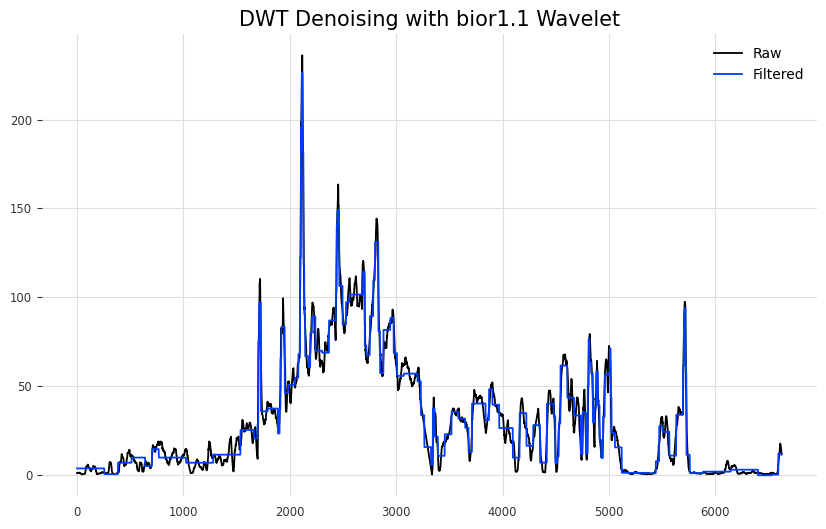

SNR: 15.574658406315507 dB
(6624,)
(6624,)


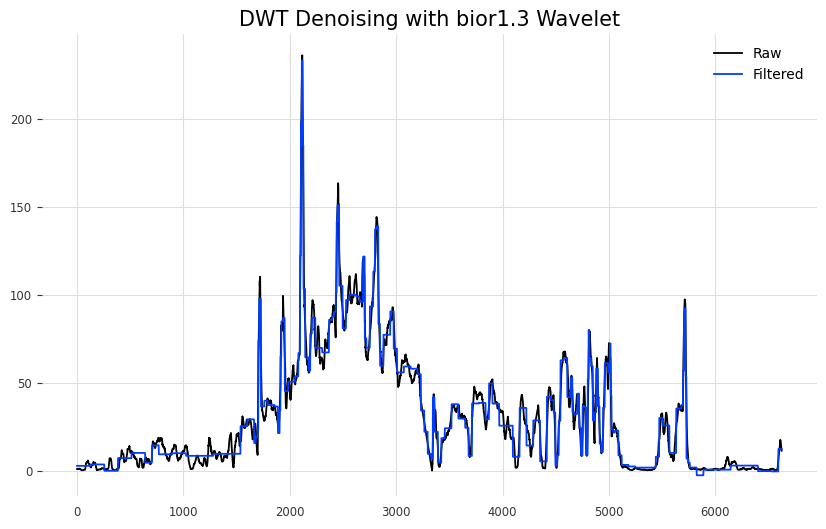

SNR: 15.364518867137551 dB
(6624,)
(6624,)


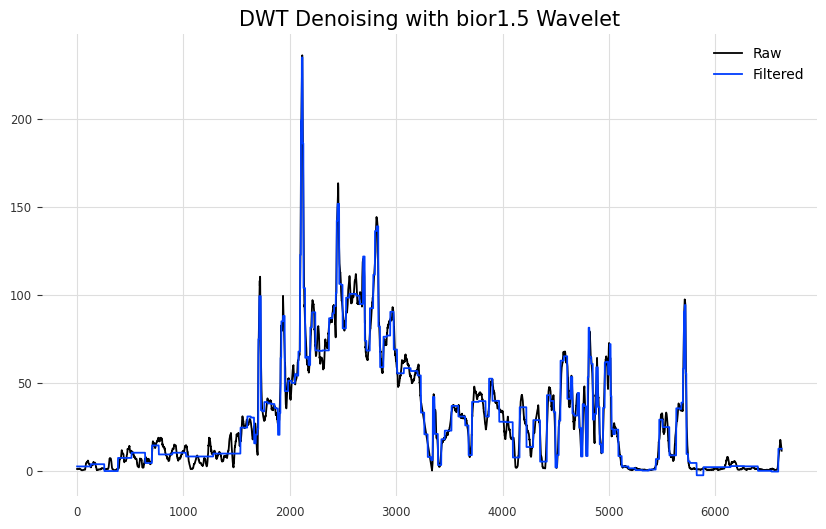

SNR: 15.30595029784928 dB
(6624,)
(6624,)


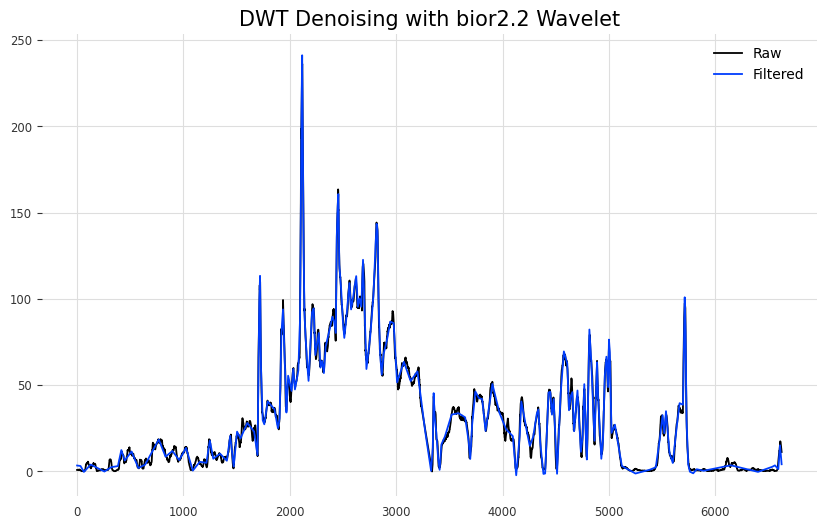

SNR: 21.7314179454395 dB
(6624,)
(6624,)


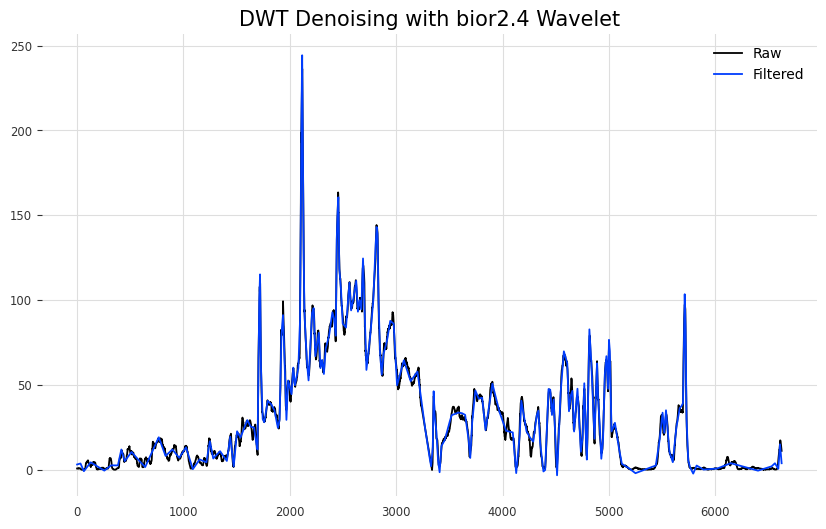

SNR: 21.77382938259139 dB
(6624,)
(6624,)


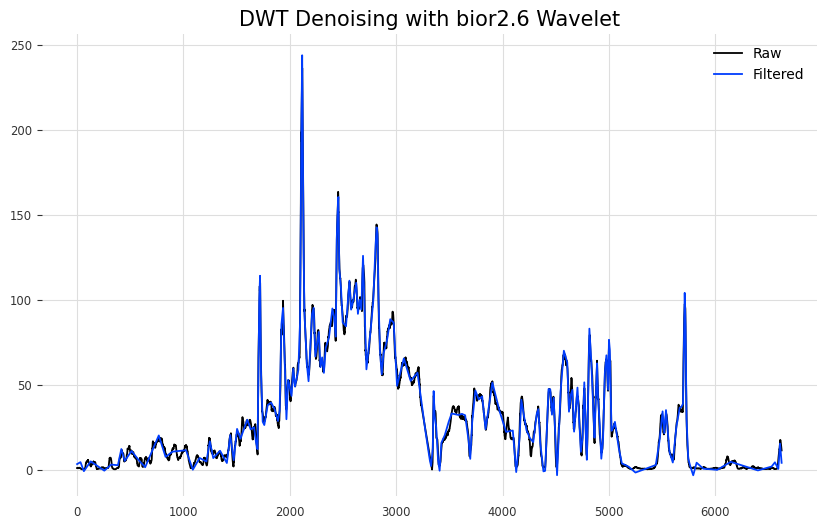

SNR: 21.511915283060567 dB
(6624,)
(6624,)


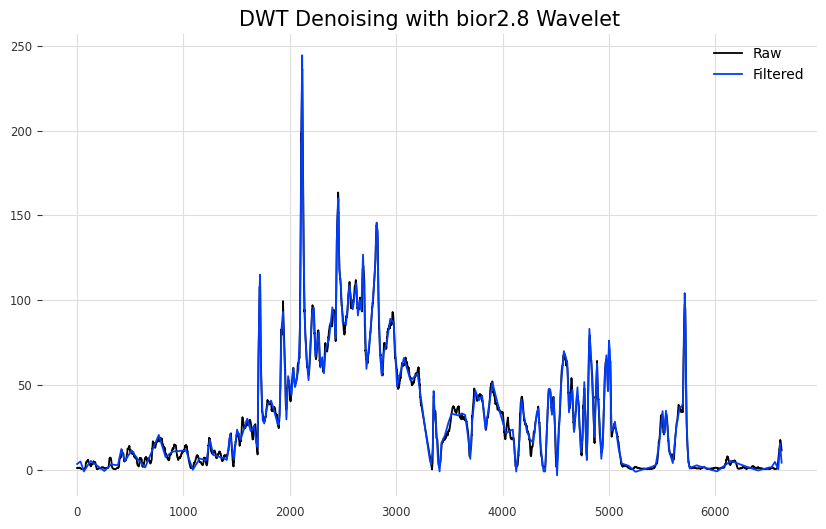

SNR: 21.479463586987045 dB
(6624,)
(6624,)


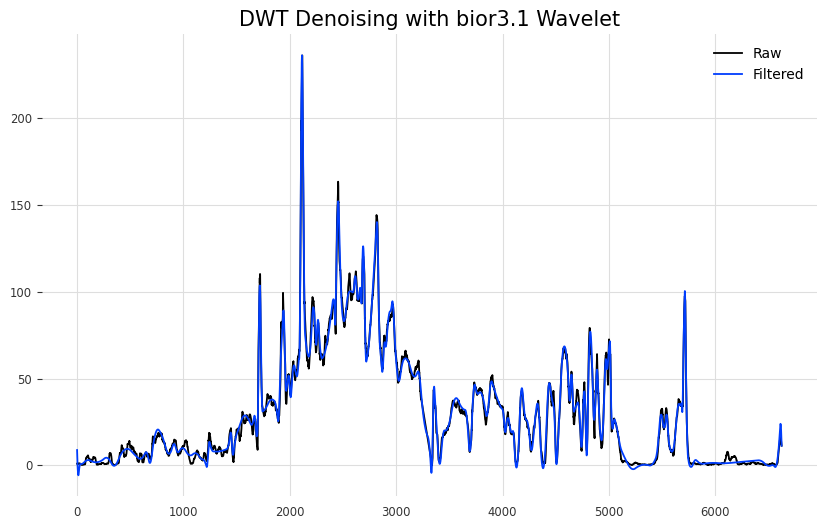

SNR: 20.598707744872733 dB
(6624,)
(6624,)


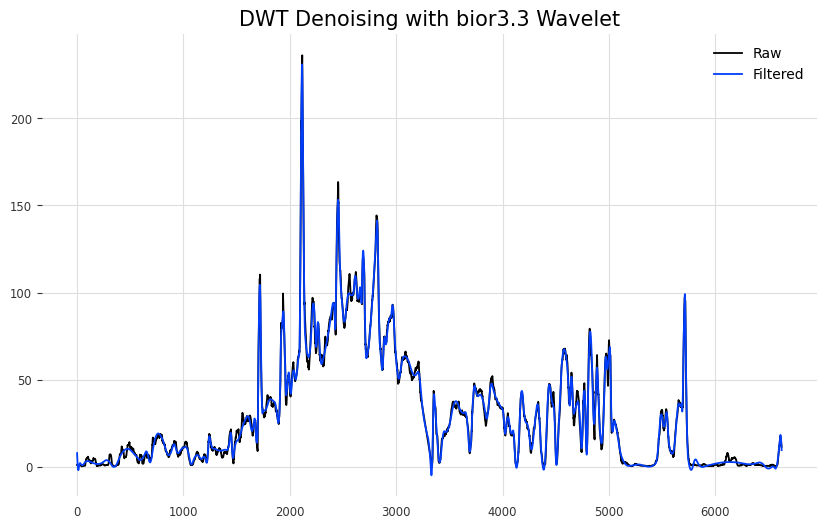

SNR: 22.456307635951504 dB
(6624,)
(6624,)


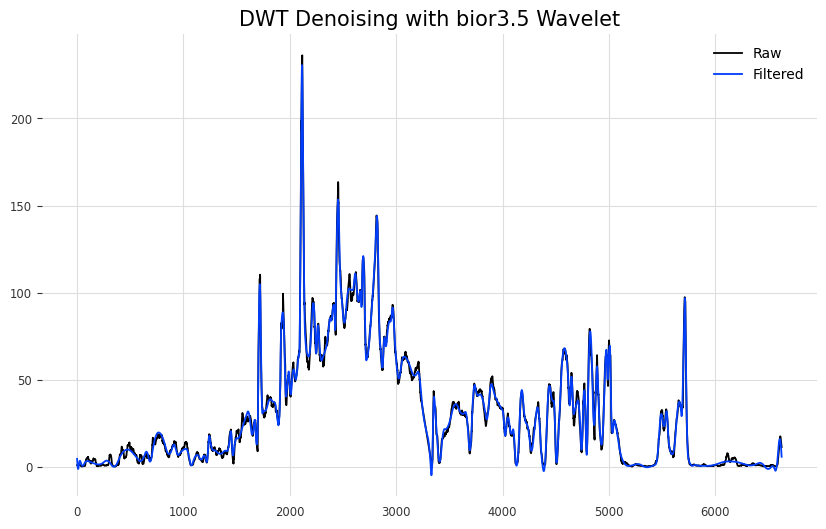

SNR: 22.577220741527274 dB
(6624,)
(6624,)


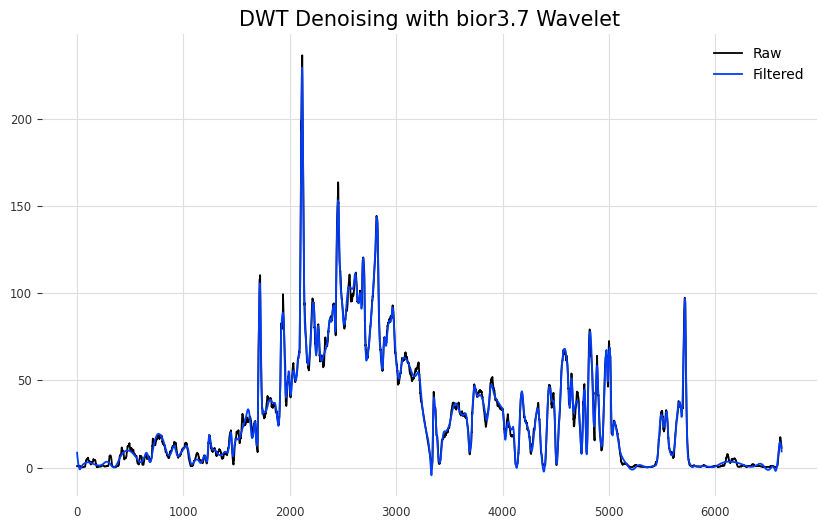

SNR: 22.588411277709213 dB
(6624,)
(6624,)


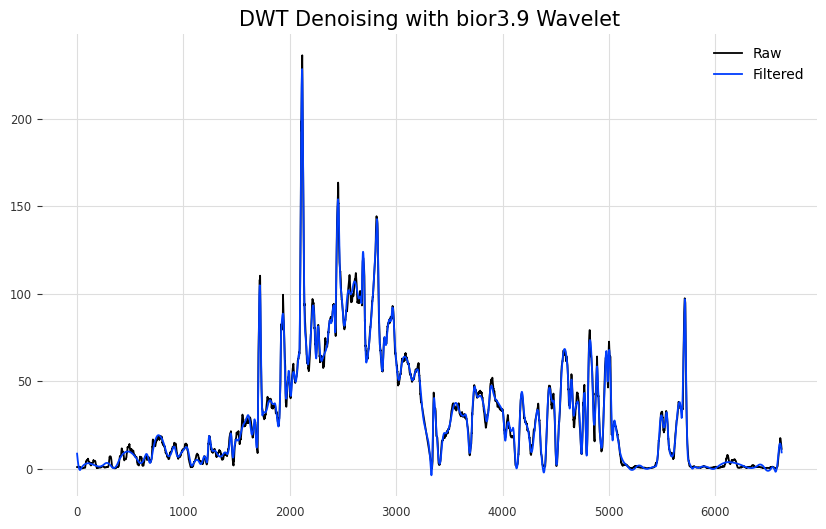

SNR: 22.7346808400325 dB
(6624,)
(6624,)


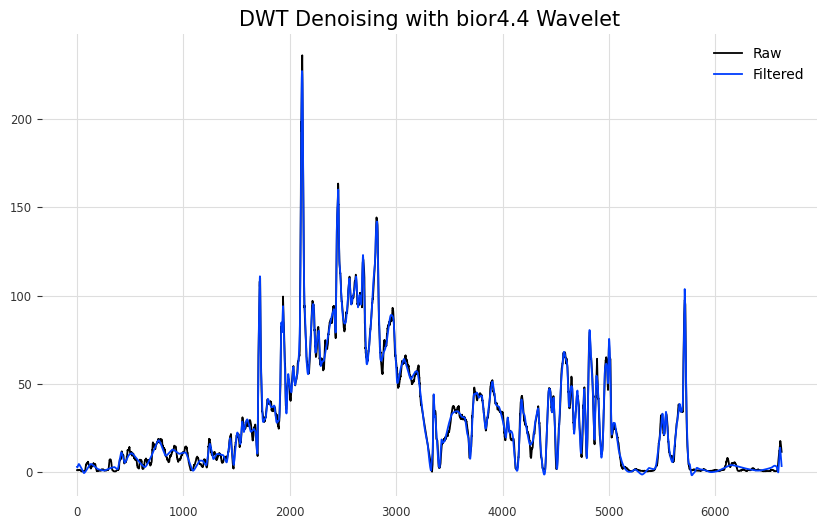

SNR: 22.38941331401111 dB
(6624,)
(6624,)


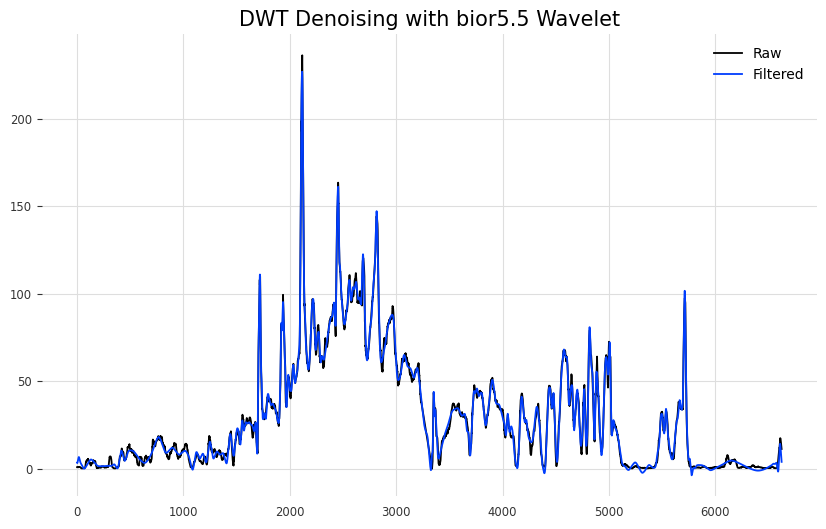

SNR: 22.398599458019323 dB
(6624,)
(6624,)


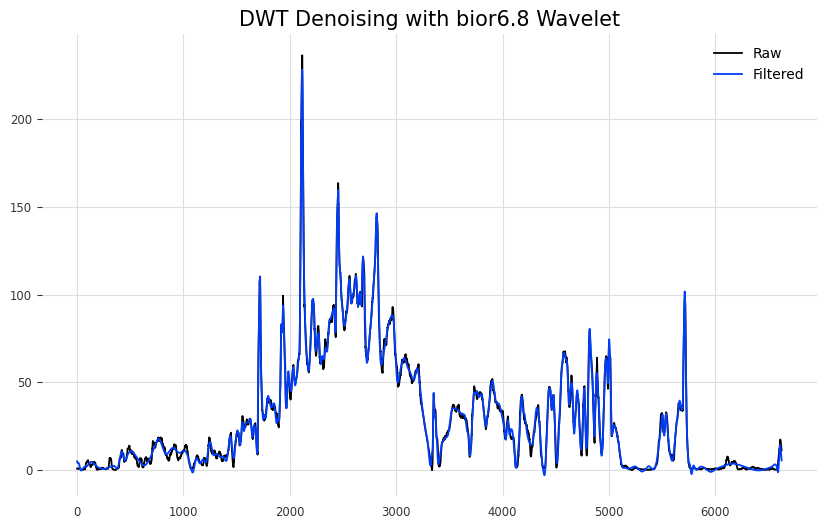

SNR: 22.880347664014597 dB
(6624,)
(6624,)


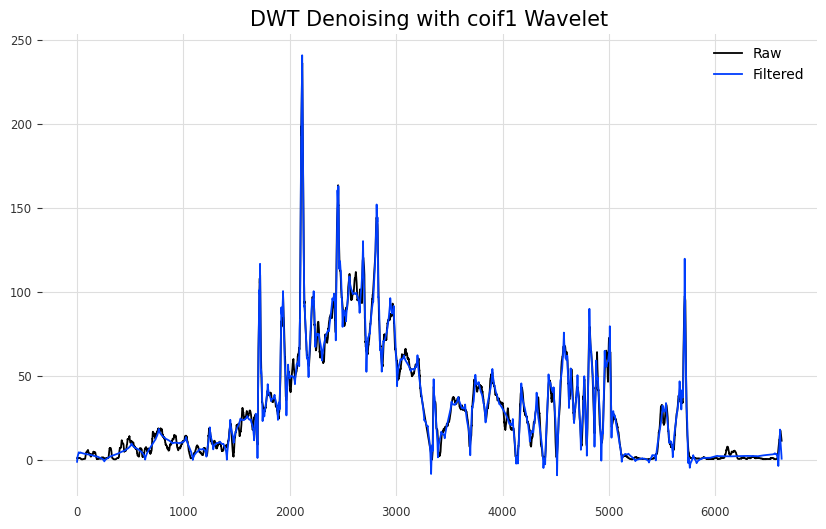

SNR: 18.86044060862838 dB
(6624,)
(6624,)


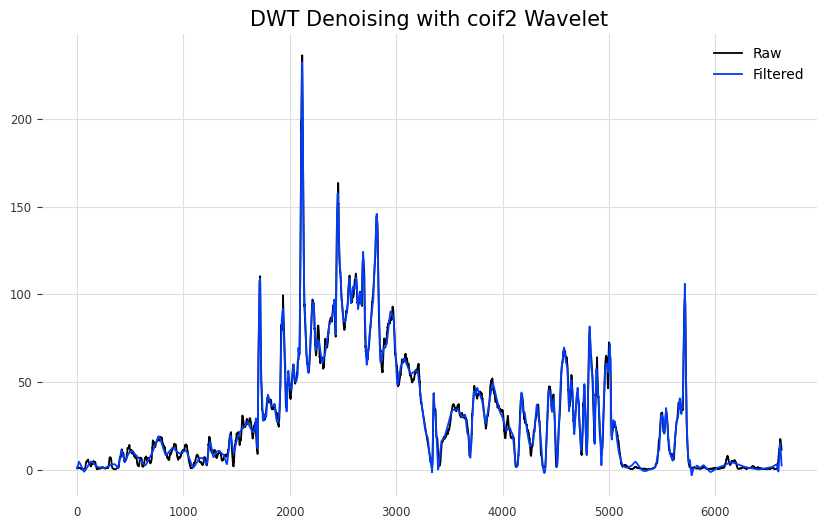

SNR: 21.05342078296769 dB
(6624,)
(6624,)


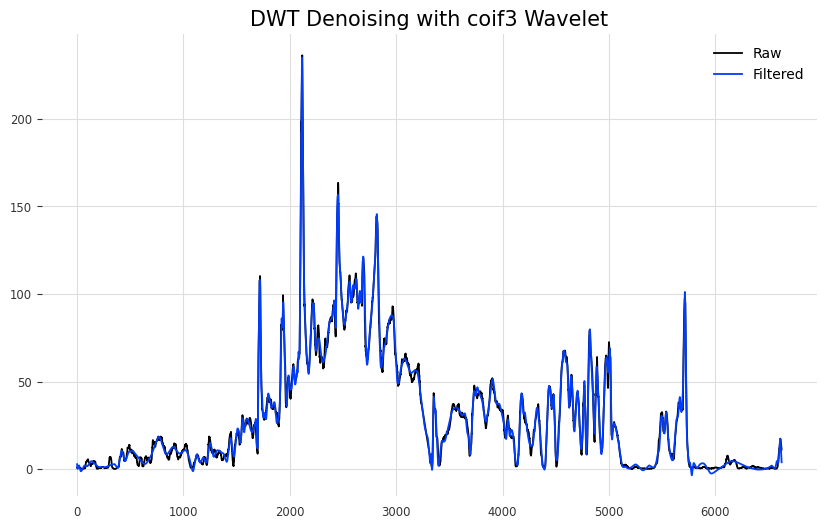

SNR: 21.938823114116886 dB
(6624,)
(6624,)


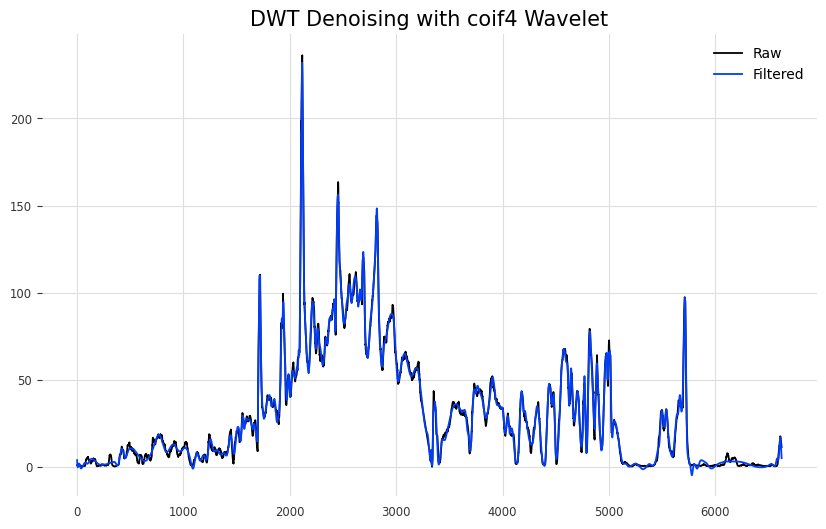

SNR: 22.49693750736273 dB
(6624,)
(6624,)


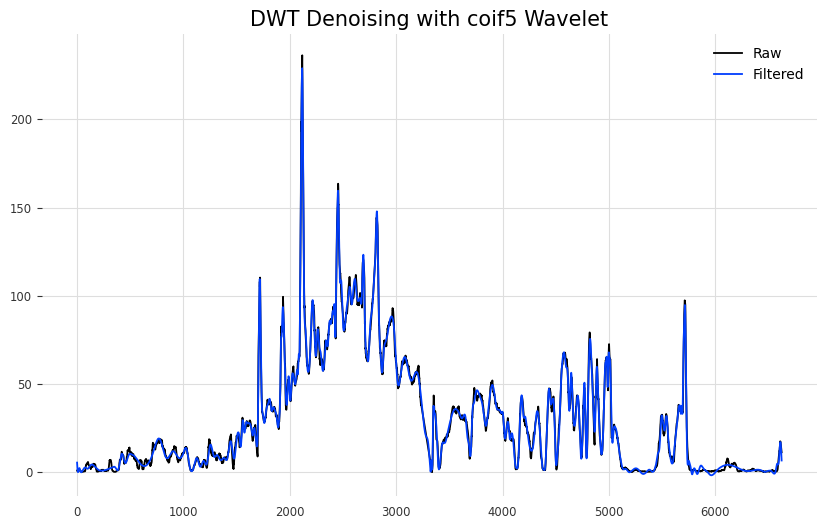

SNR: 22.797528971965086 dB
(6624,)
(6624,)


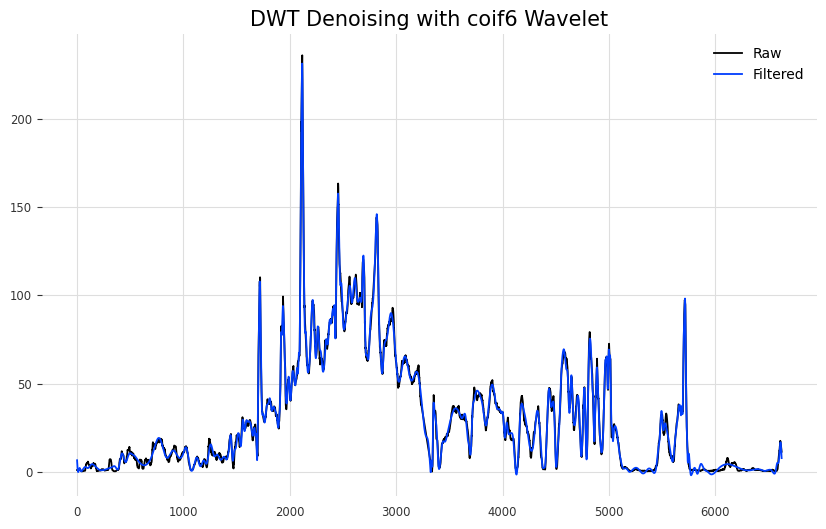

SNR: 22.862967766728246 dB
(6624,)
(6624,)


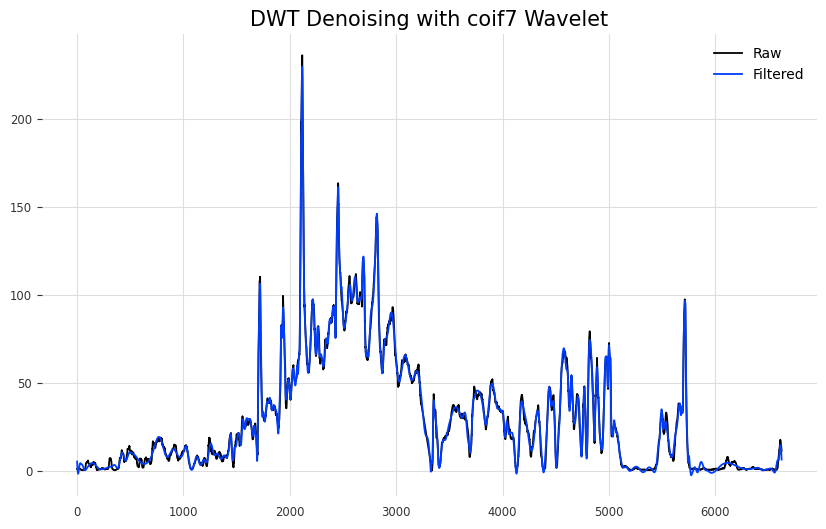

SNR: 22.926223610621044 dB
(6624,)
(6624,)


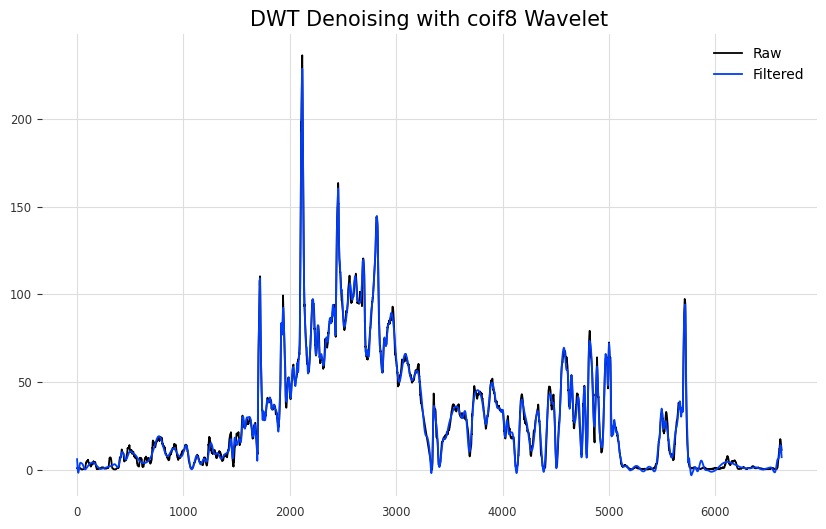

SNR: 22.55422151947794 dB
(6624,)
(6624,)


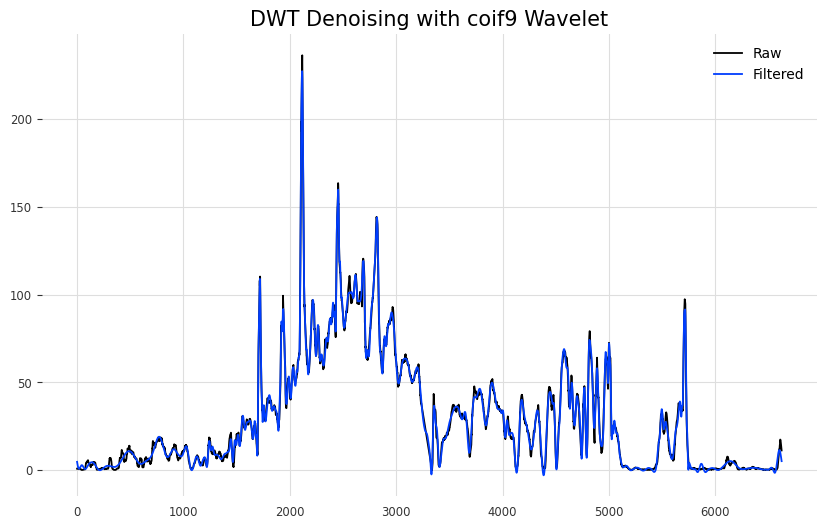

SNR: 23.056824878110014 dB
(6624,)
(6624,)


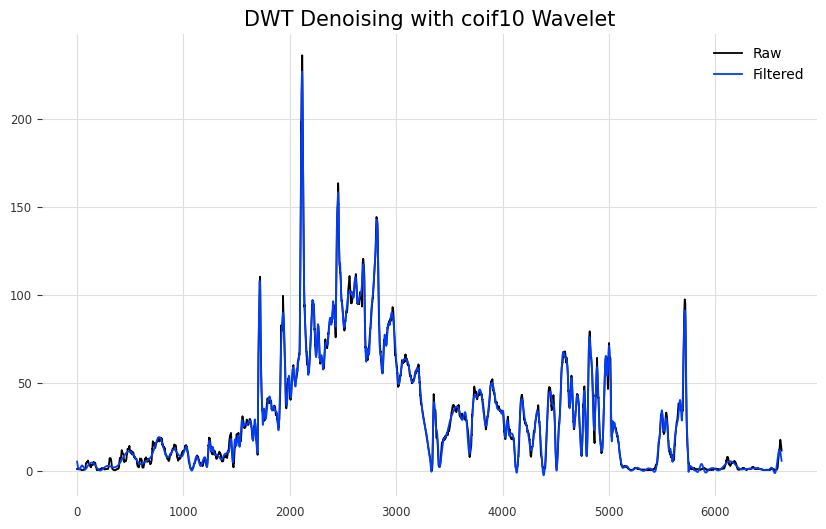

SNR: 23.0195692853121 dB
(6624,)
(6624,)


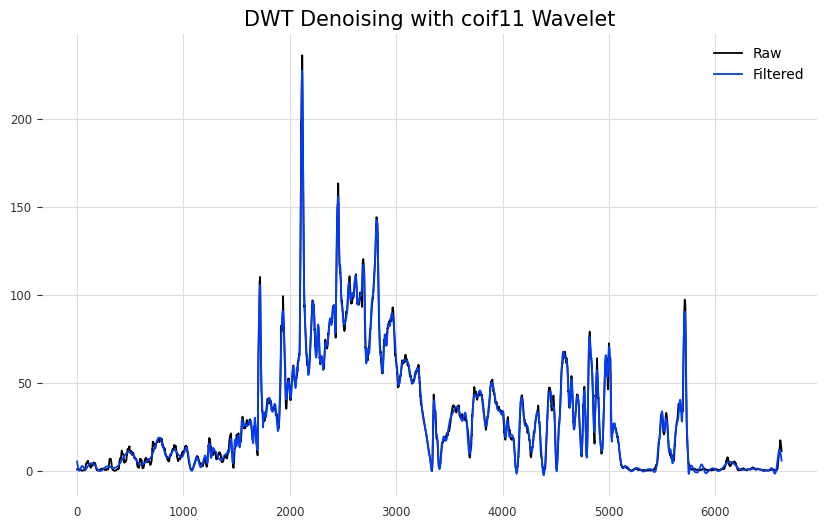

SNR: 23.13266643323105 dB
(6624,)
(6624,)


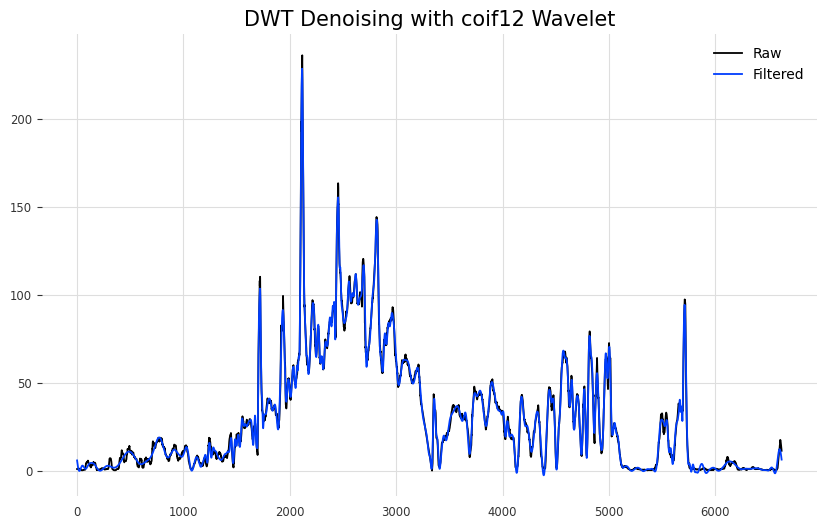

SNR: 23.171322430588816 dB
(6624,)
(6624,)


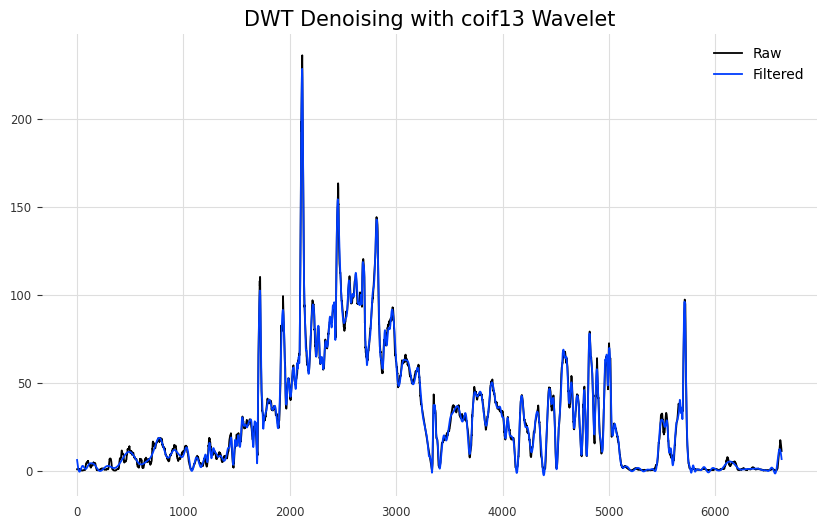

SNR: 23.363743131029807 dB
(6624,)
(6624,)


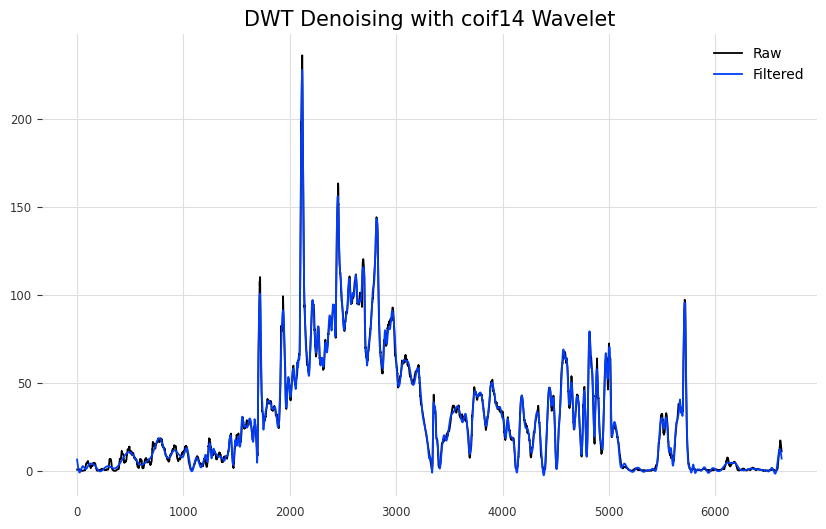

SNR: 23.499436771022143 dB
(6624,)
(6624,)


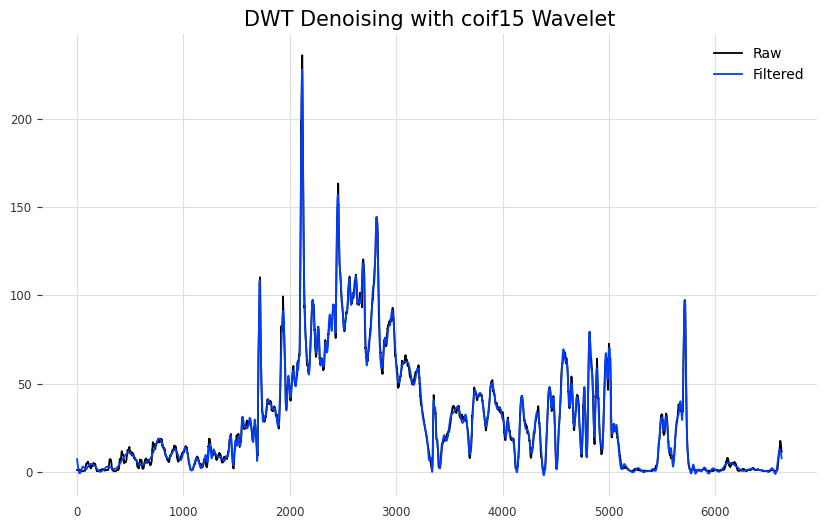

SNR: 23.64001090565609 dB
(6624,)
(6624,)


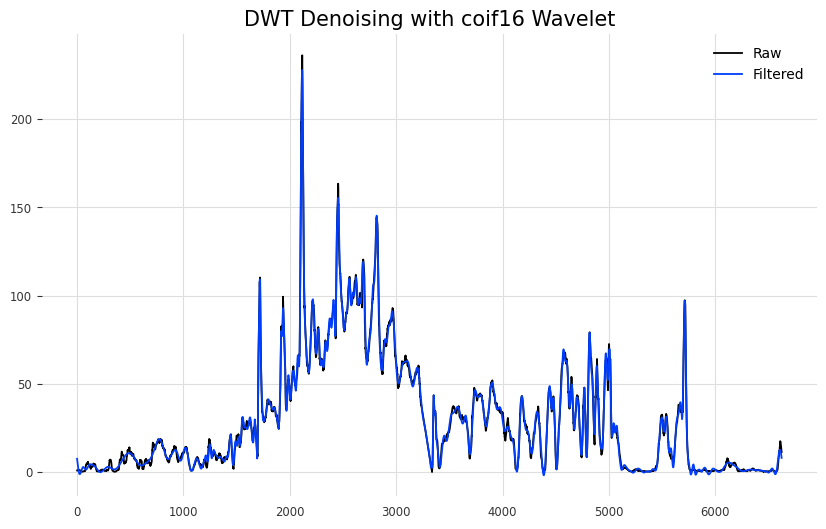

SNR: 23.964338866639547 dB
(6624,)
(6624,)


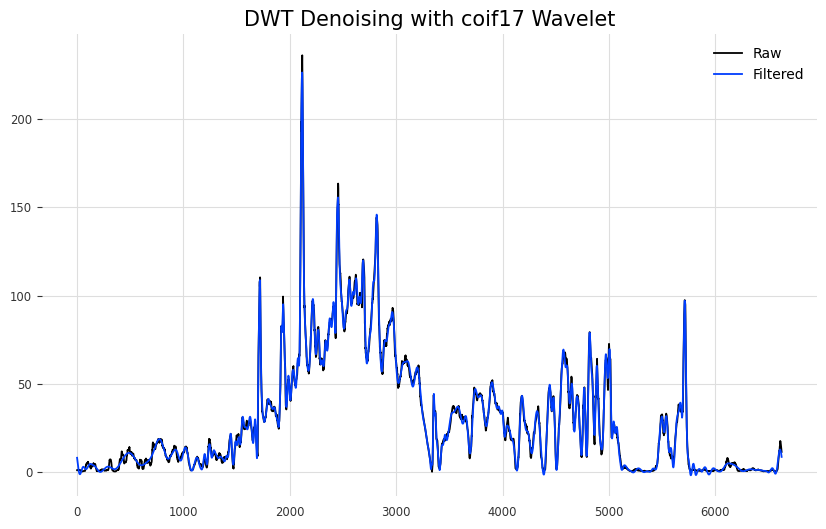

SNR: 24.159933794637563 dB
(6624,)
(6624,)


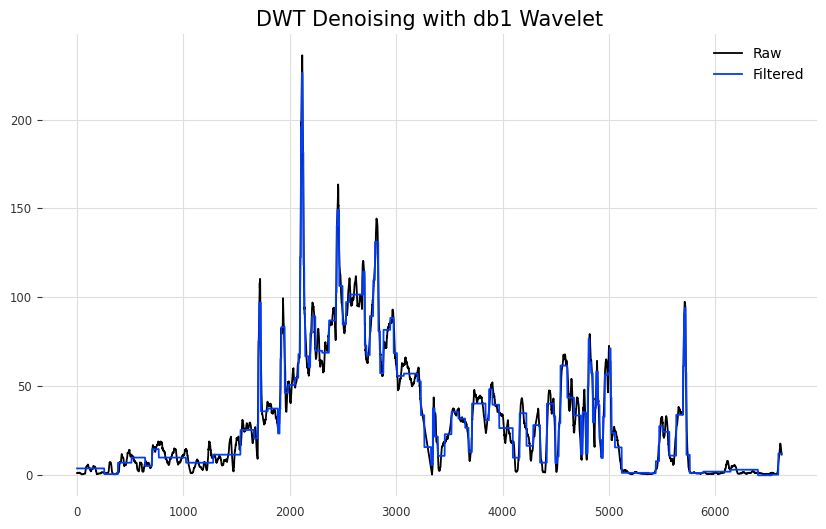

SNR: 15.574658406315507 dB
(6624,)
(6624,)


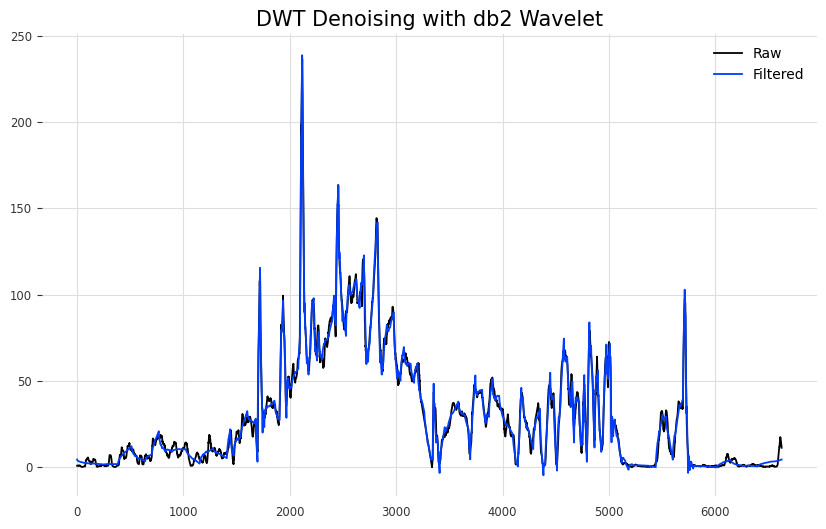

SNR: 19.431162897881656 dB
(6624,)
(6624,)


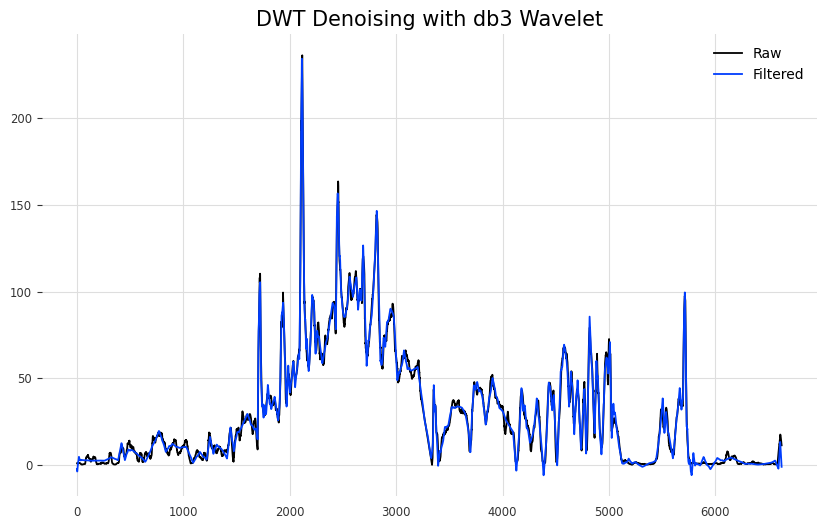

SNR: 20.273906217818848 dB
(6624,)
(6624,)


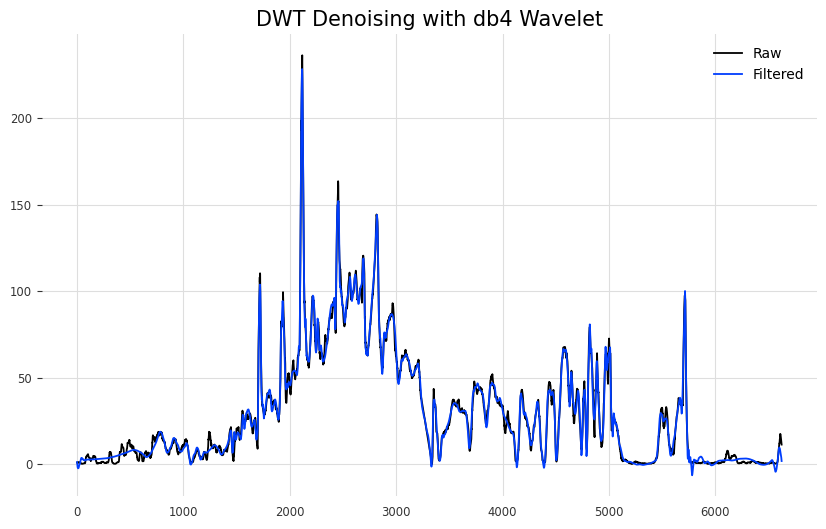

SNR: 20.543688093897018 dB
(6624,)
(6624,)


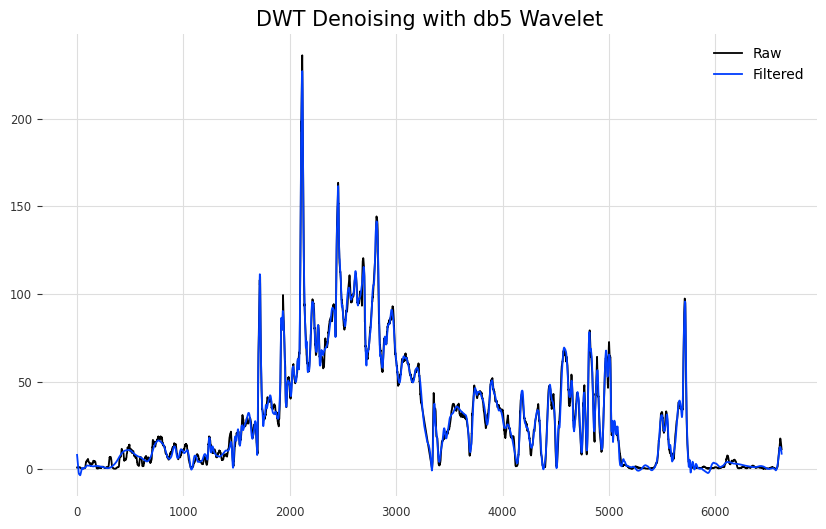

SNR: 21.669706738056846 dB
(6624,)
(6624,)


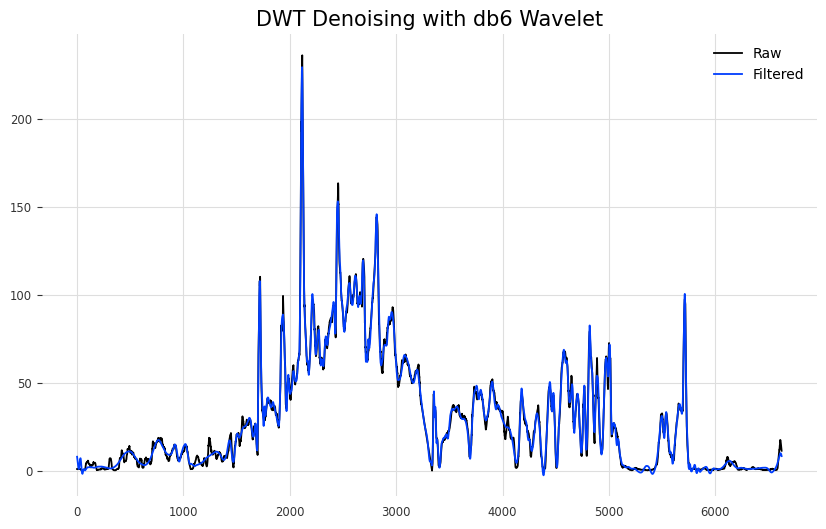

SNR: 22.312699705549377 dB
(6624,)
(6624,)


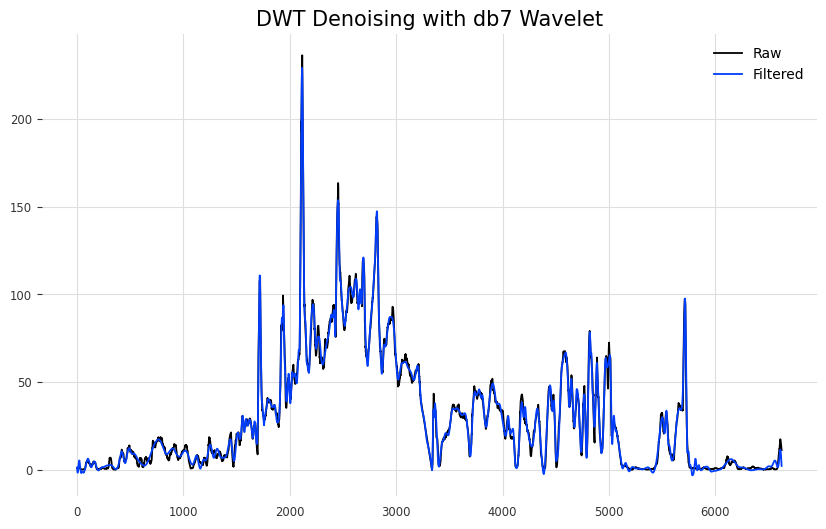

SNR: 21.926815739626907 dB
(6624,)
(6624,)


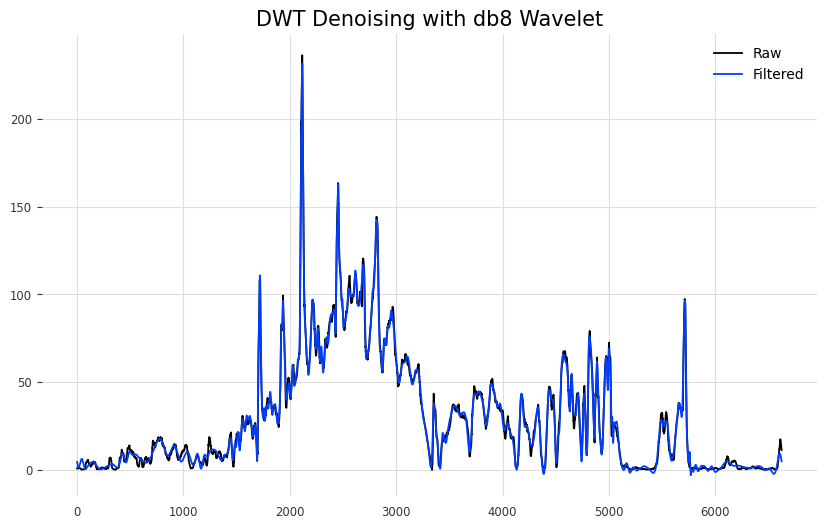

SNR: 21.77056338653991 dB
(6624,)
(6624,)


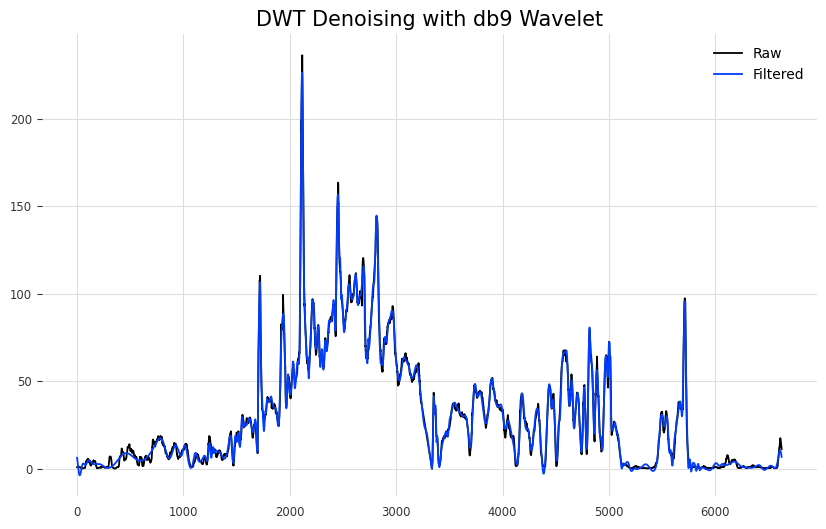

SNR: 22.61943607808966 dB
(6624,)
(6624,)


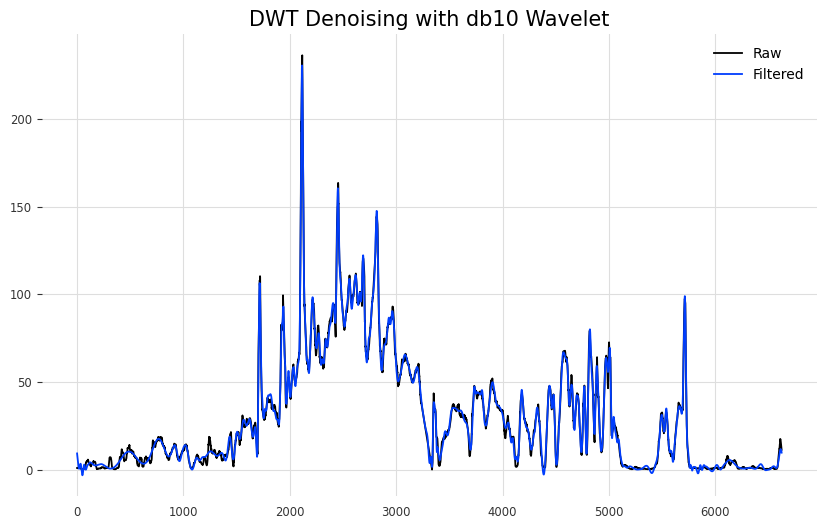

SNR: 22.786498706981043 dB
(6624,)
(6624,)


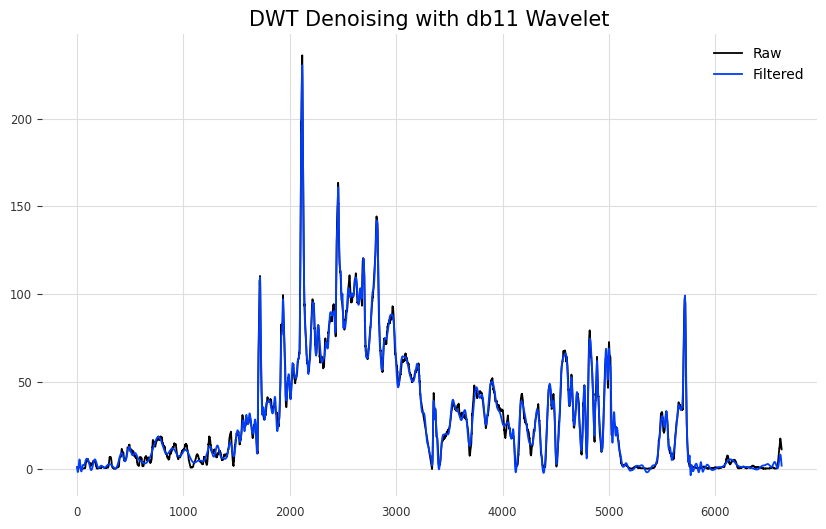

SNR: 21.751025452639748 dB
(6624,)
(6624,)


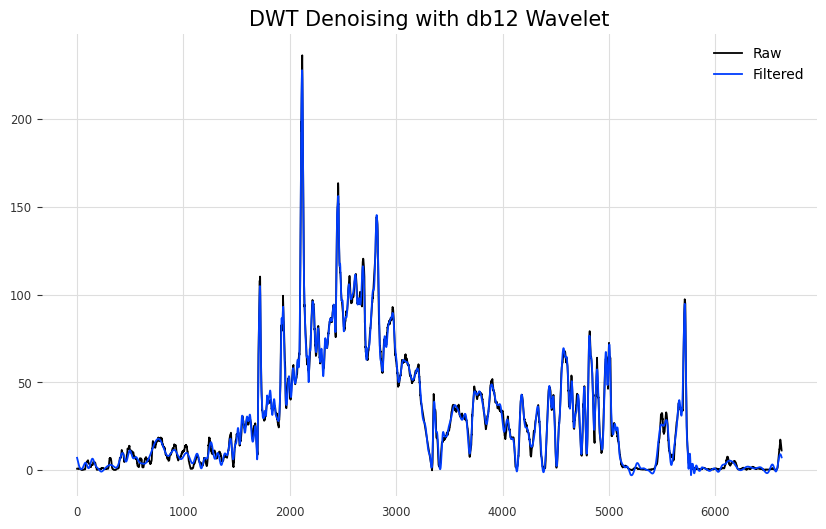

SNR: 22.137071798641287 dB
(6624,)
(6624,)


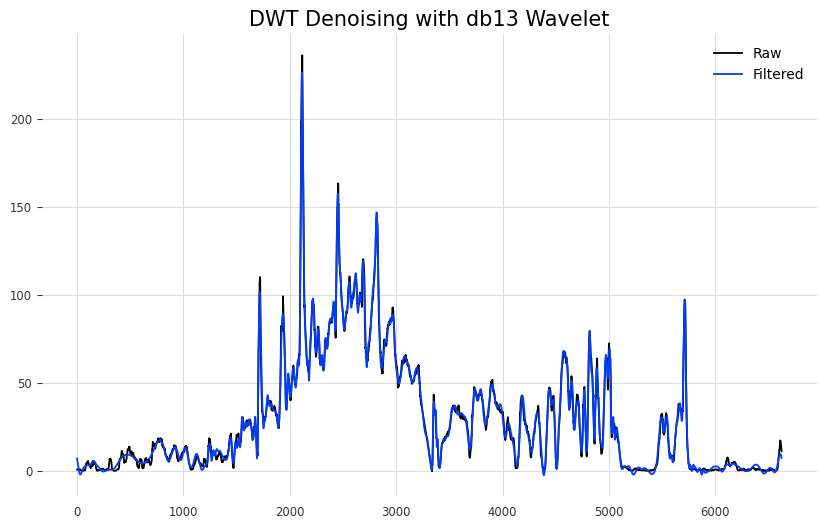

SNR: 22.515217921200332 dB
(6624,)
(6624,)


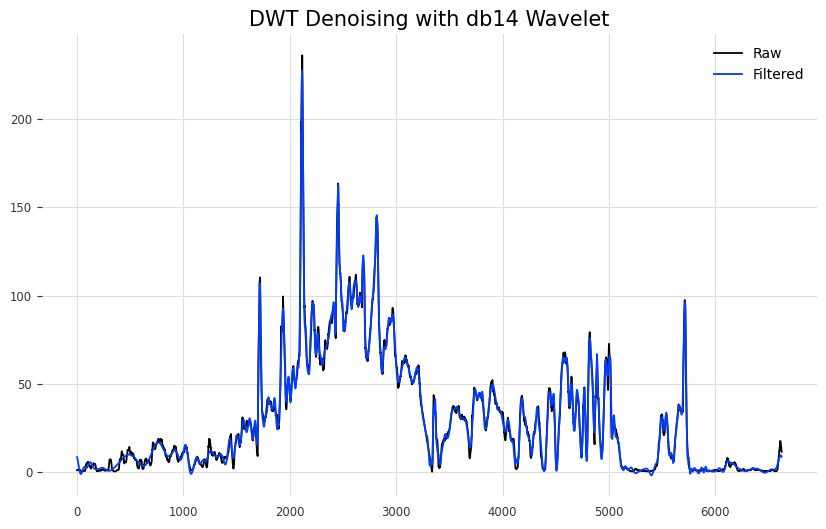

SNR: 22.287722917512806 dB
(6624,)
(6624,)


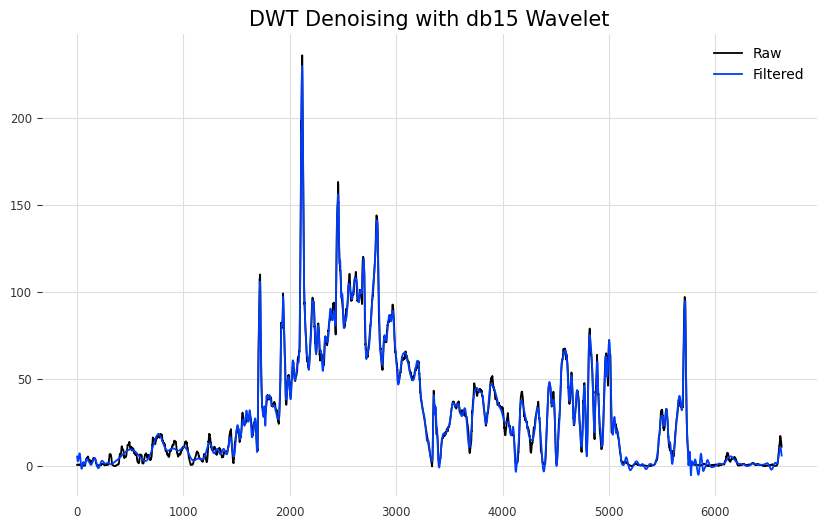

SNR: 22.17054982008353 dB
(6624,)
(6624,)


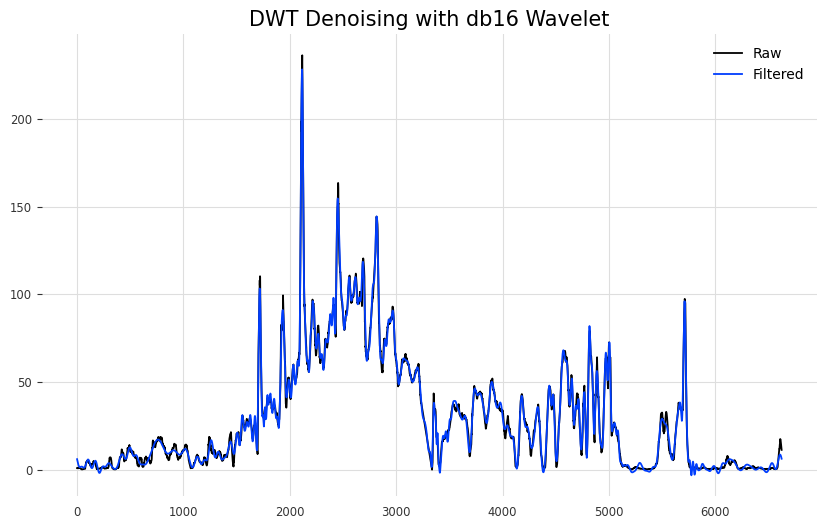

SNR: 22.240195356165422 dB
(6624,)
(6624,)


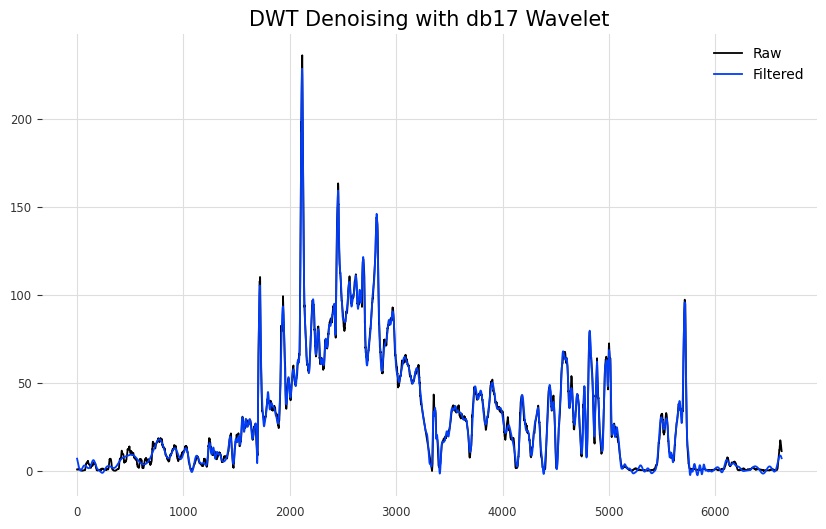

SNR: 23.245432075027143 dB
(6624,)
(6624,)


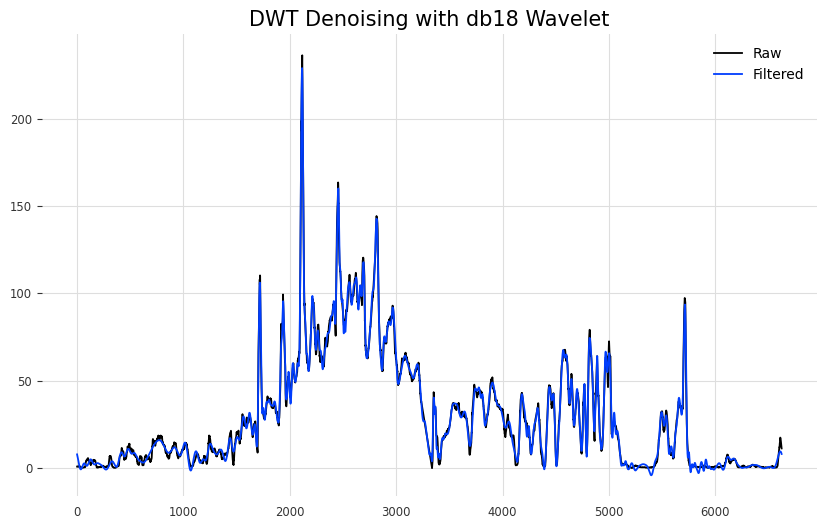

SNR: 21.99657564160844 dB
(6624,)
(6624,)


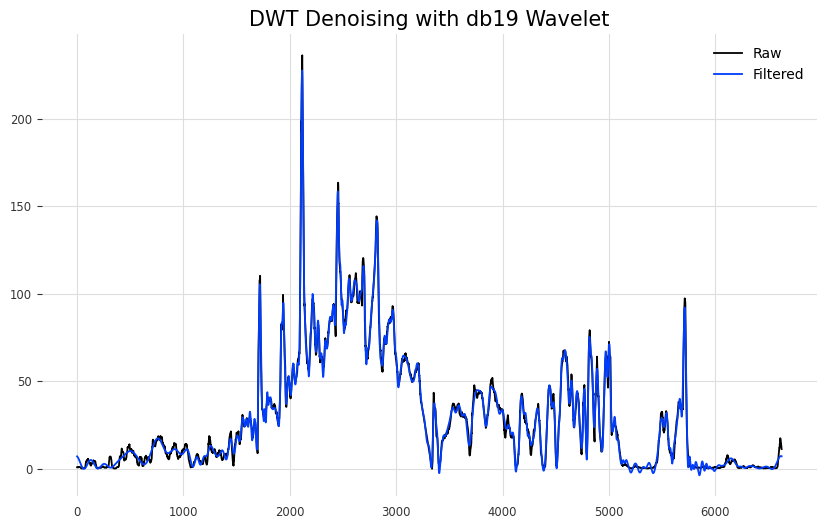

SNR: 21.80797063558856 dB
(6624,)
(6624,)


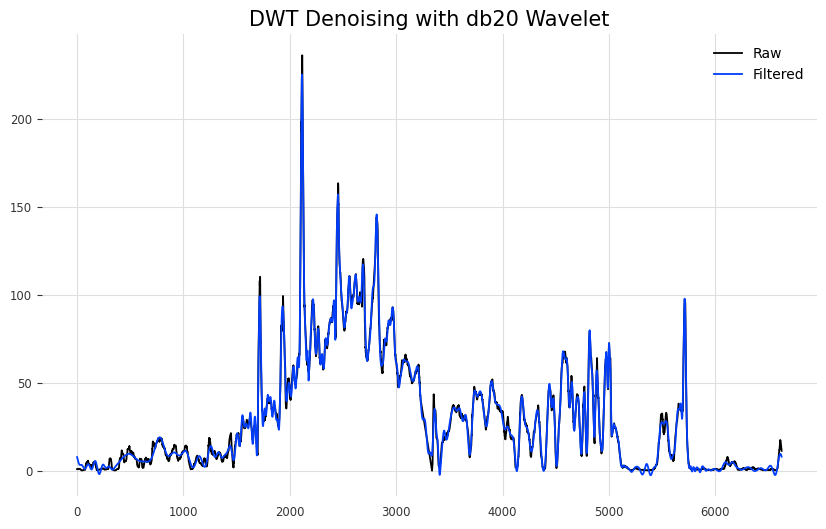

SNR: 22.49607932468022 dB
(6624,)
(6624,)


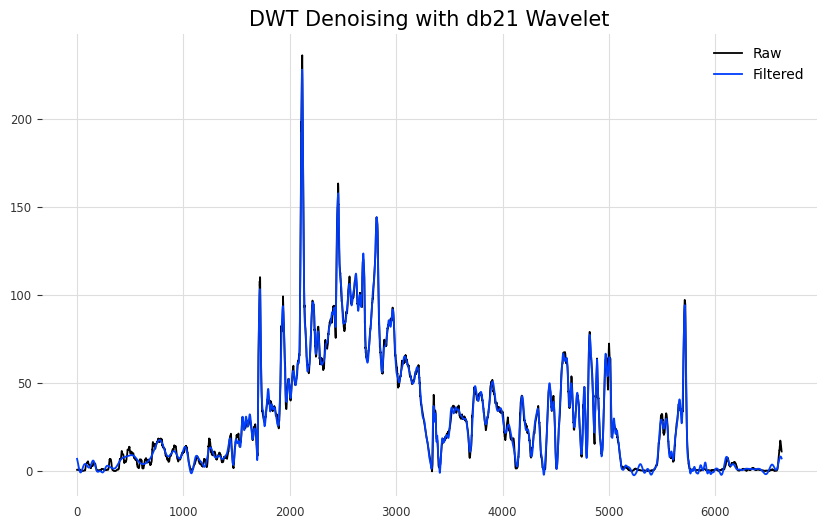

SNR: 22.880884631710398 dB
(6624,)
(6624,)


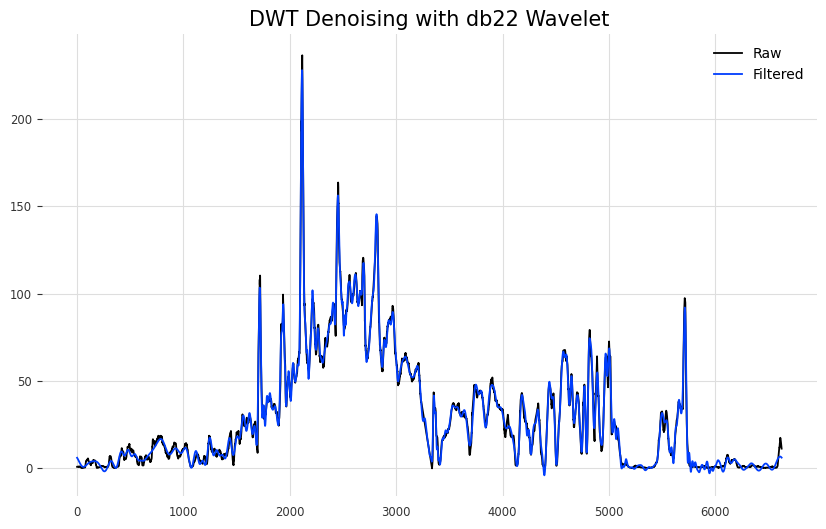

SNR: 21.611157103025313 dB
(6624,)
(6624,)


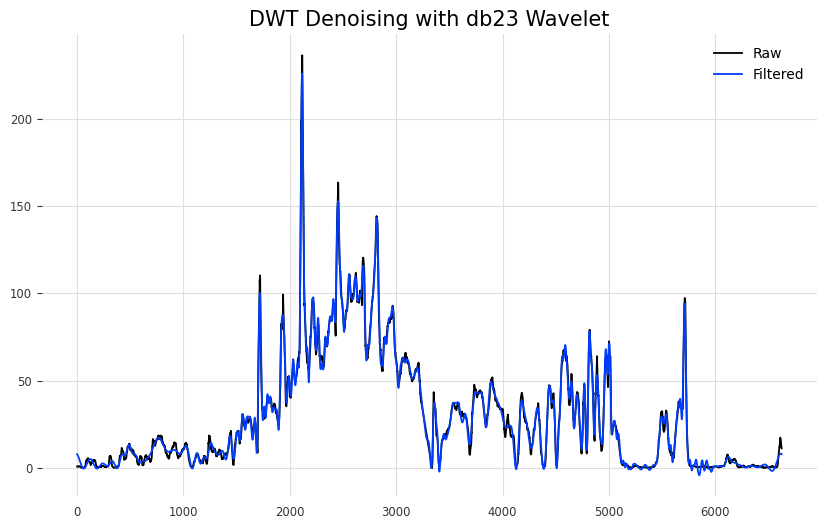

SNR: 21.71099630544536 dB
(6624,)
(6624,)


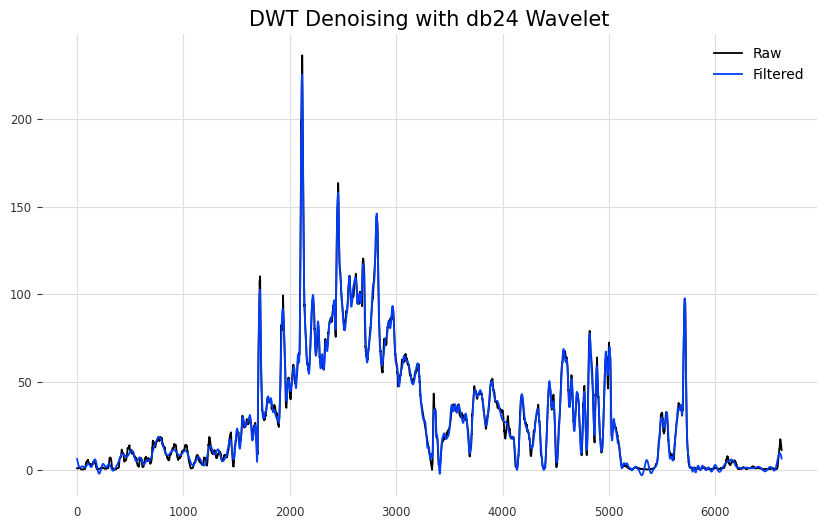

SNR: 22.773789543403584 dB
(6624,)
(6624,)


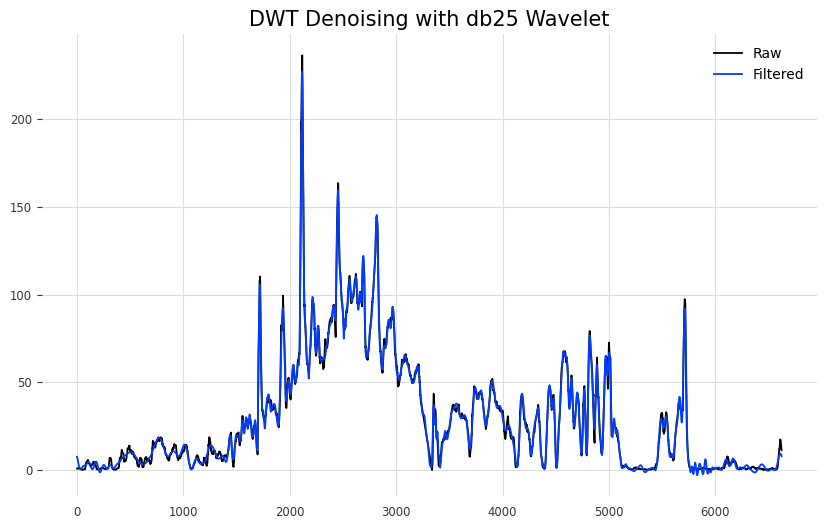

SNR: 22.464473869425774 dB
(6624,)
(6624,)


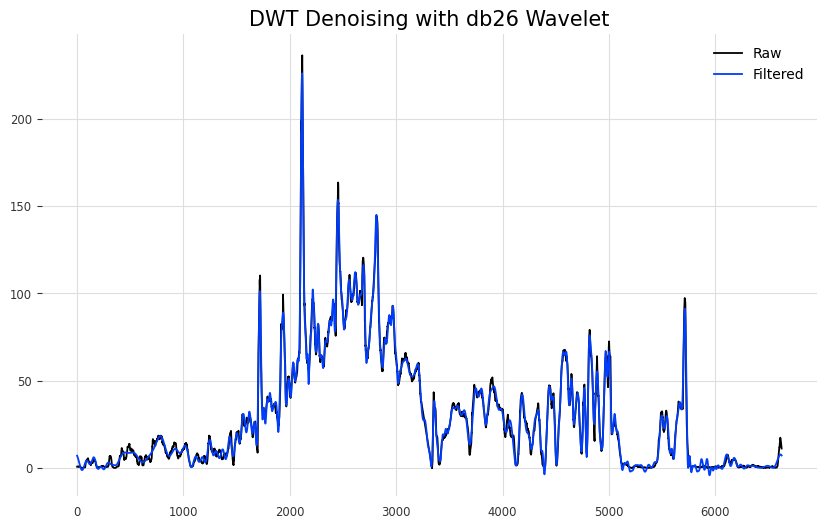

SNR: 21.382271183934908 dB
(6624,)
(6624,)


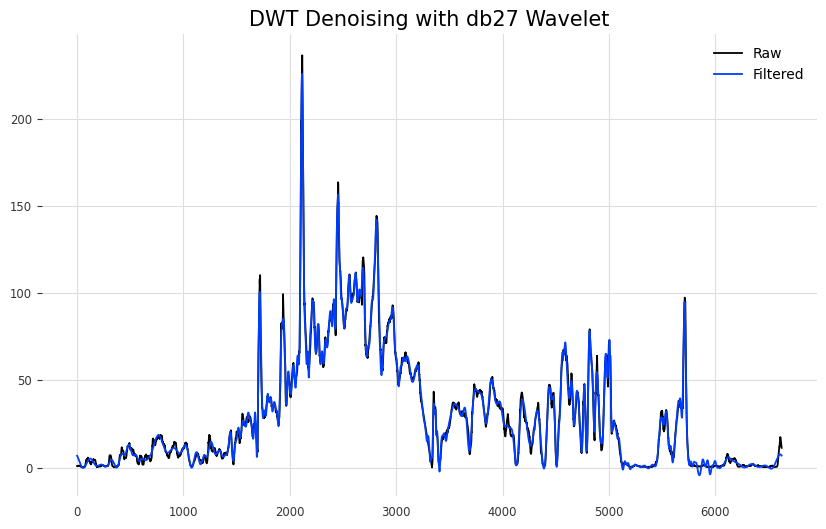

SNR: 21.980359220441915 dB
(6624,)
(6624,)


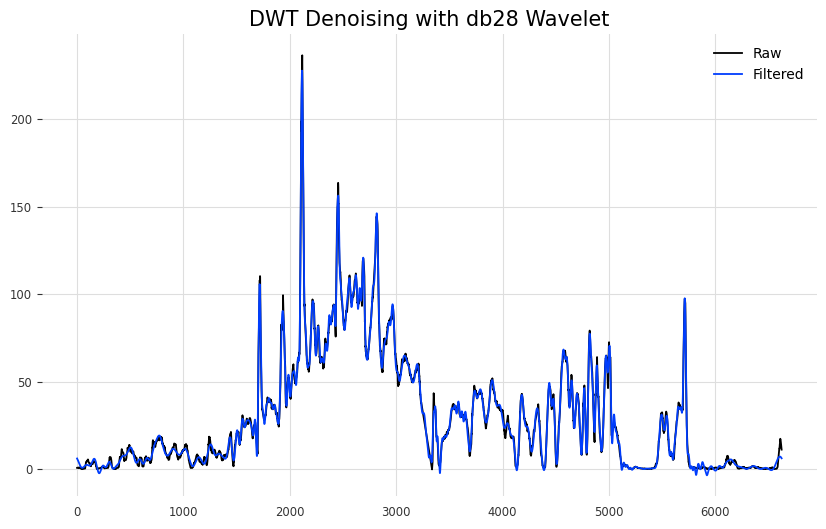

SNR: 23.37948140476582 dB
(6624,)
(6624,)


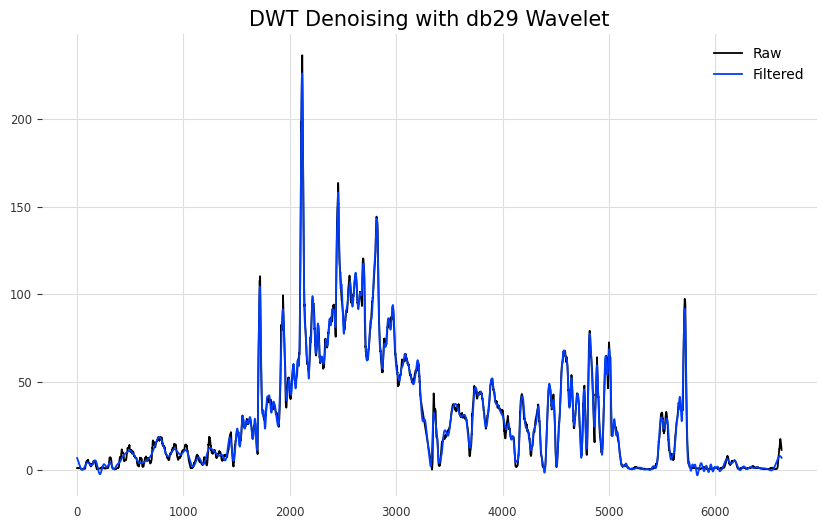

SNR: 22.01851211854294 dB
(6624,)
(6624,)


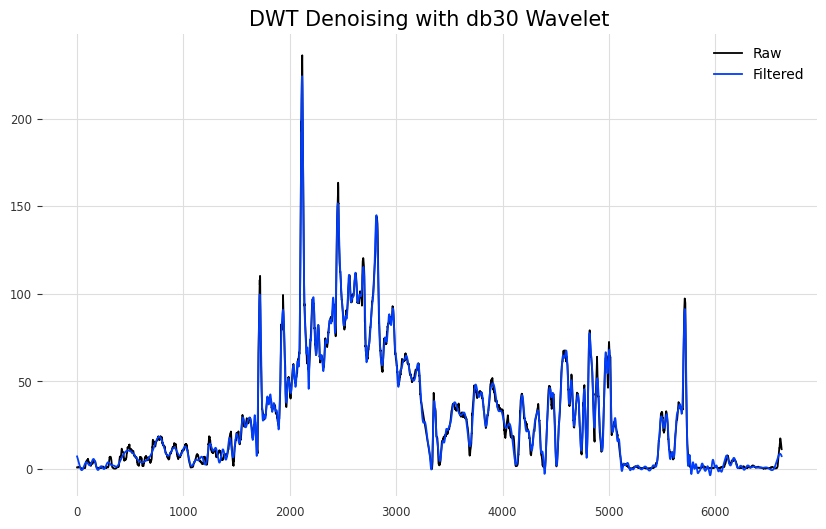

SNR: 21.567401223543484 dB
(6624,)
(6624,)


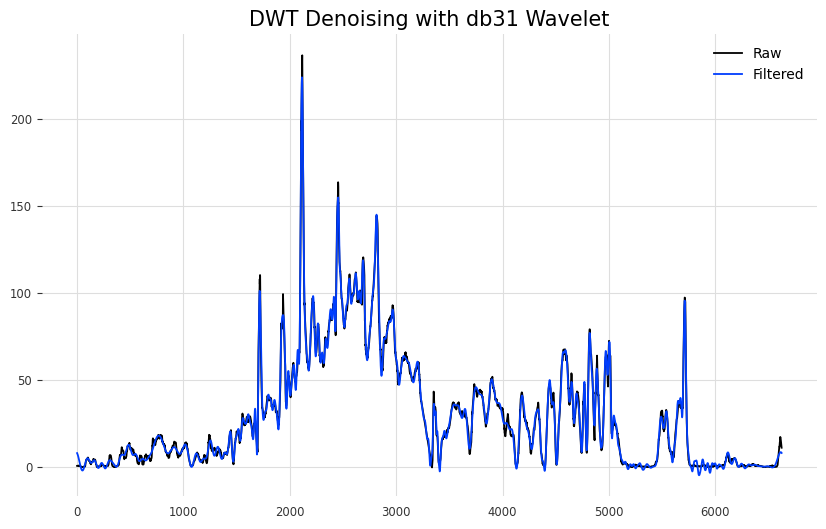

SNR: 22.515343186826374 dB
(6624,)
(6624,)


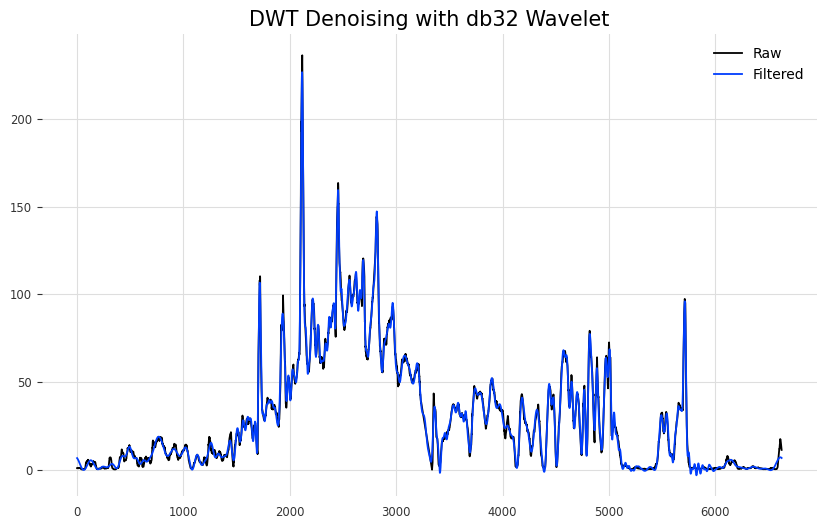

SNR: 22.808423207999397 dB
(6624,)
(6624,)


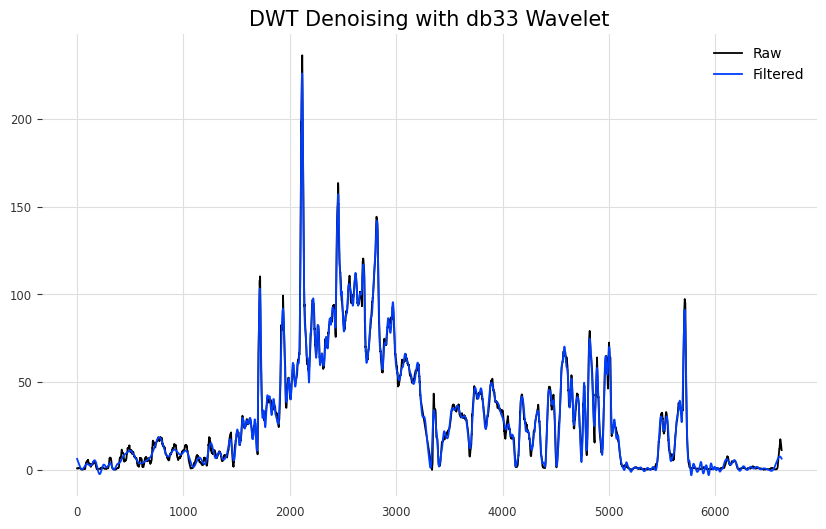

SNR: 21.83462402729794 dB
(6624,)
(6624,)


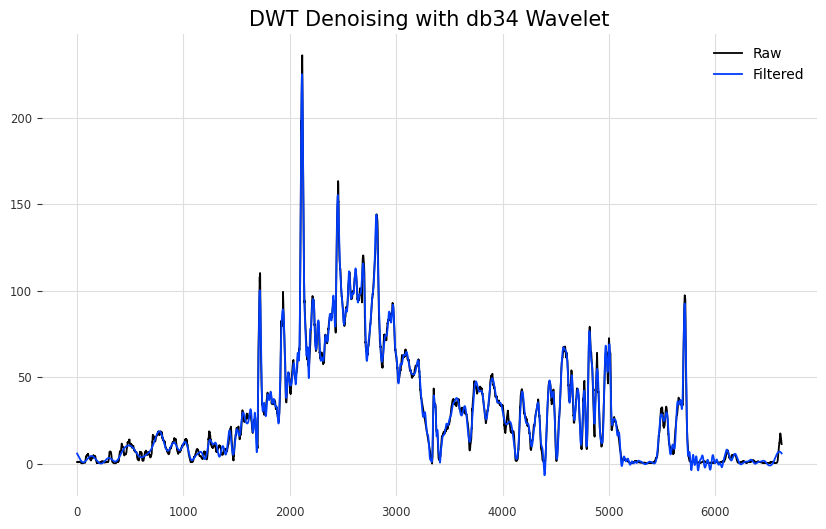

SNR: 21.708439642187205 dB
(6624,)
(6624,)


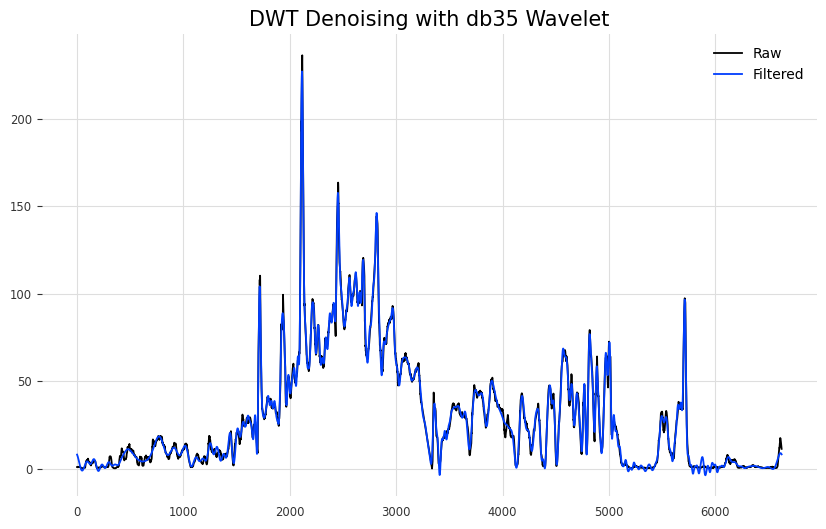

SNR: 22.642612687360895 dB
(6624,)
(6624,)


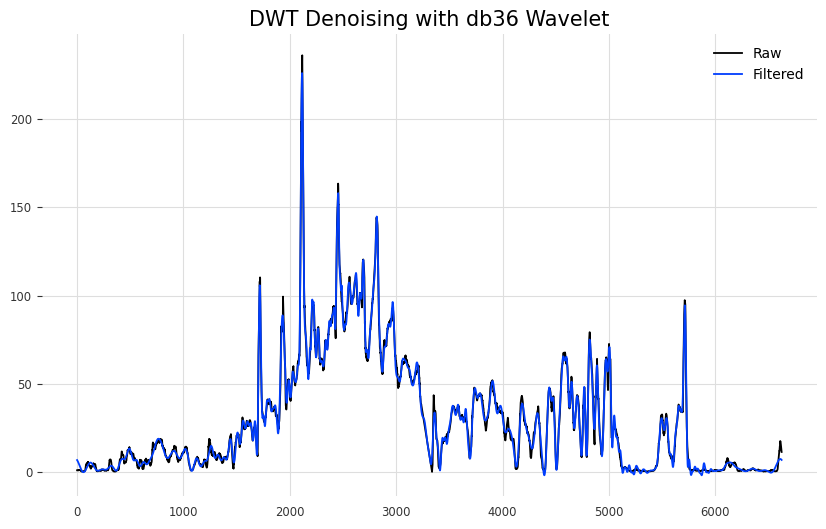

SNR: 22.231600383913438 dB
(6624,)
(6624,)


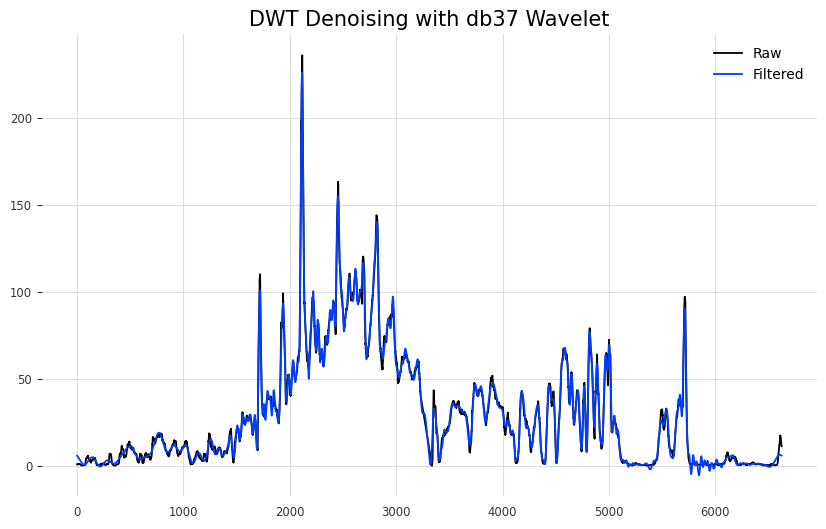

SNR: 21.67047139095982 dB
(6624,)
(6624,)


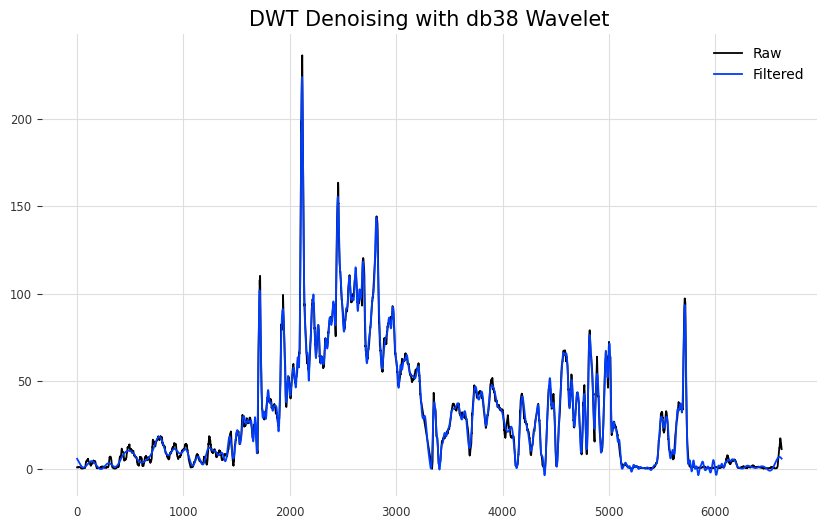

SNR: 21.78078860962795 dB
(6624,)
(6624,)


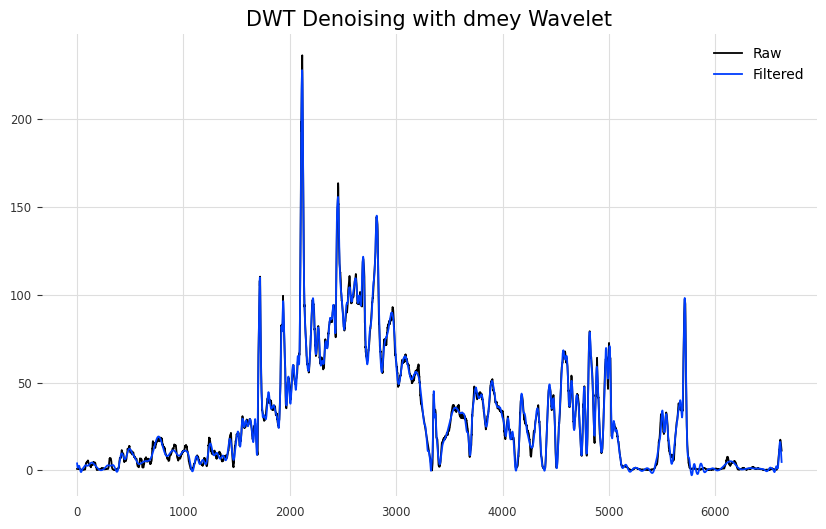

SNR: 23.535335652596586 dB
(6624,)
(6624,)


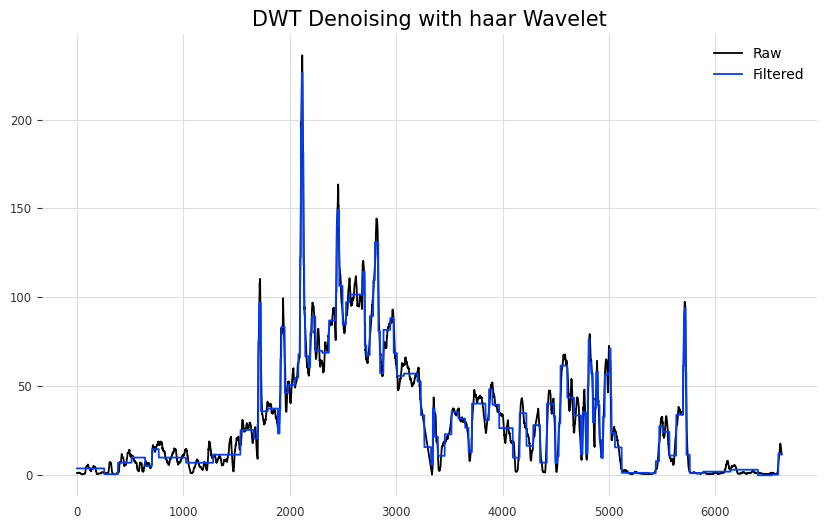

SNR: 15.574658406315507 dB
(6624,)
(6624,)


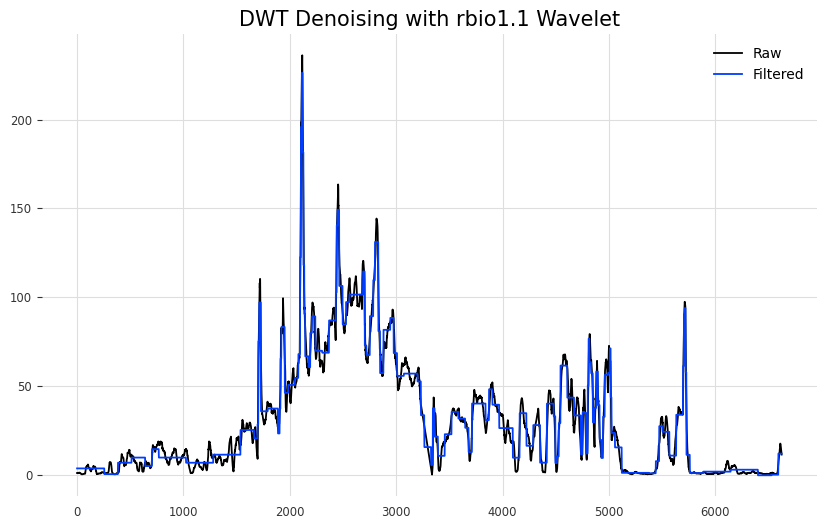

SNR: 15.574658406315507 dB
(6624,)
(6624,)


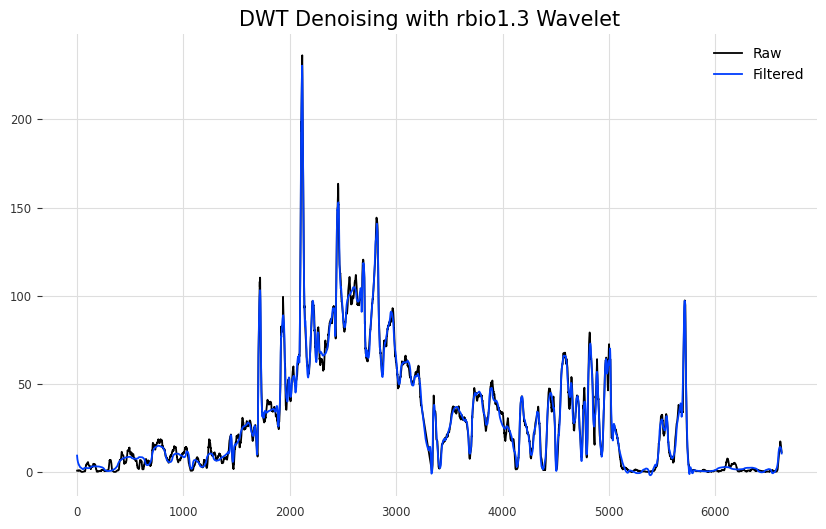

SNR: 20.622899995151542 dB
(6624,)
(6624,)


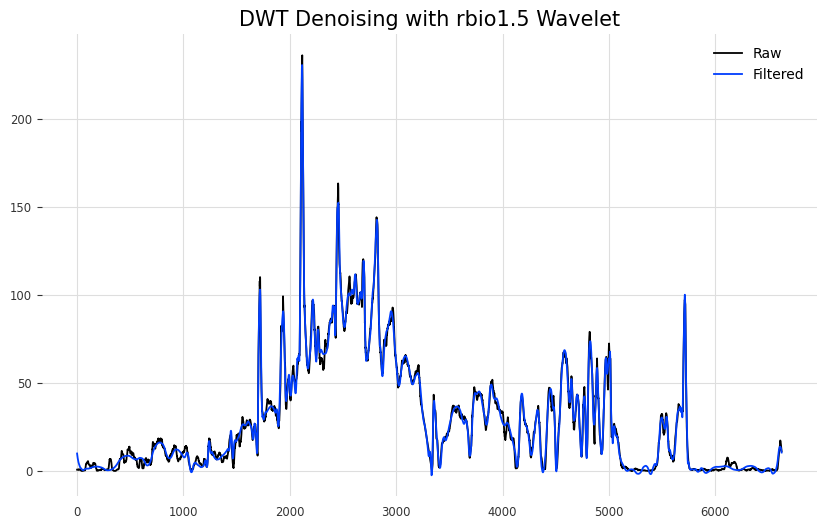

SNR: 21.21393663590444 dB
(6624,)
(6624,)


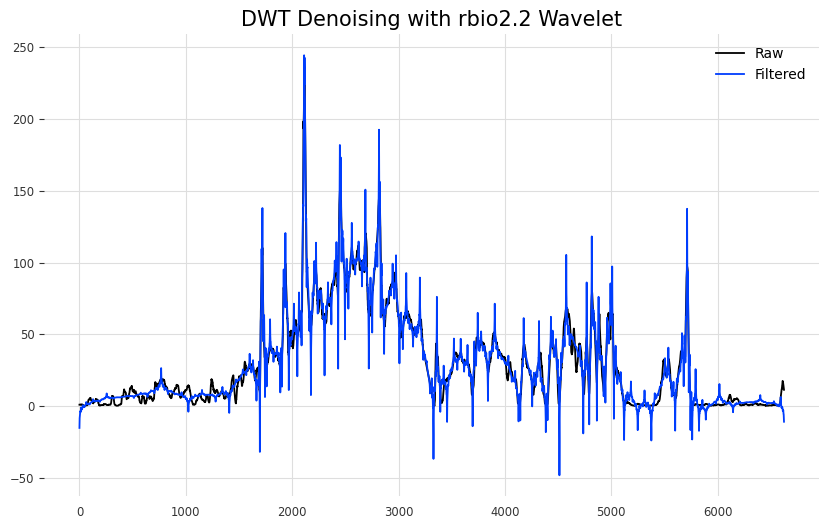

SNR: 13.741985978863813 dB
(6624,)
(6624,)


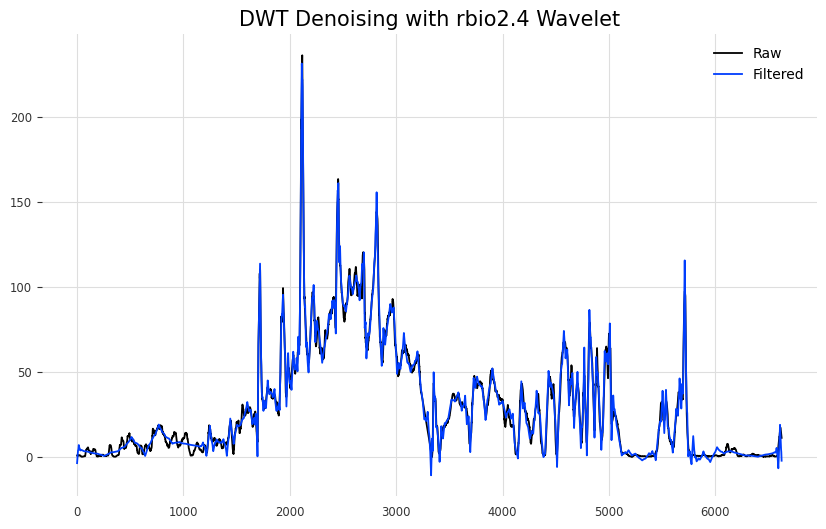

SNR: 19.152768014301444 dB
(6624,)
(6624,)


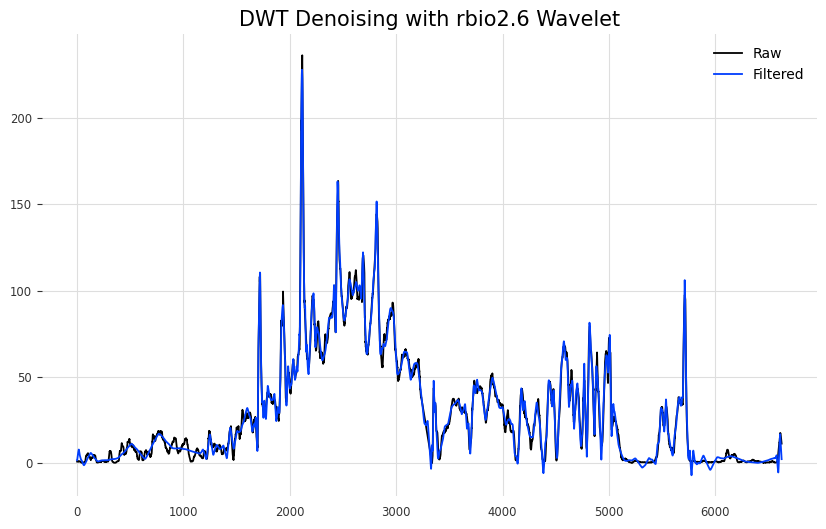

SNR: 19.929855913508238 dB
(6624,)
(6624,)


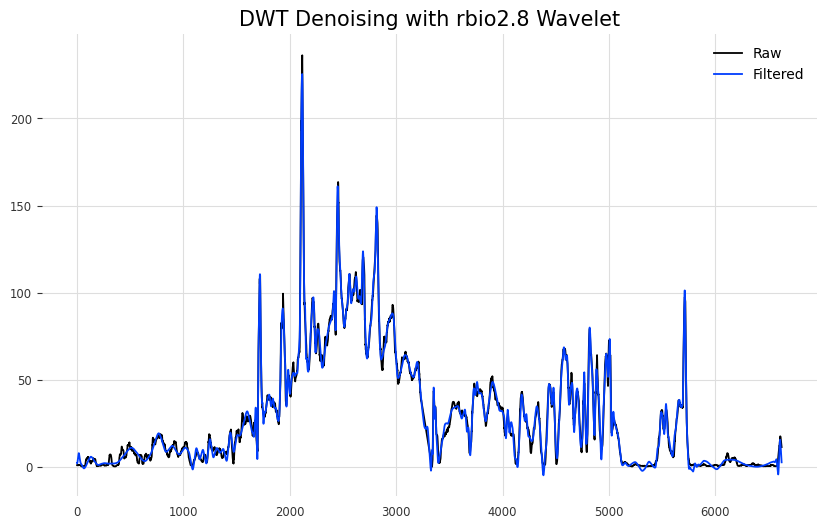

SNR: 20.896921227404736 dB
(6624,)
(6624,)


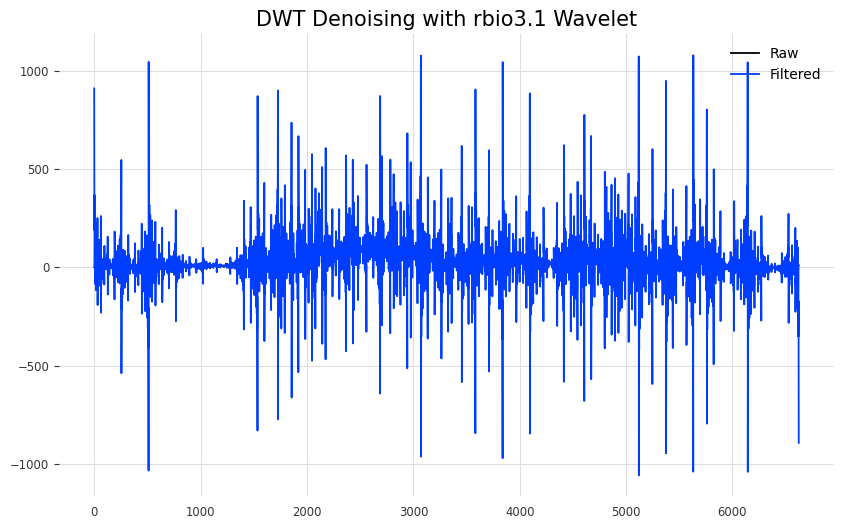

SNR: -11.525776099491566 dB
(6624,)
(6624,)


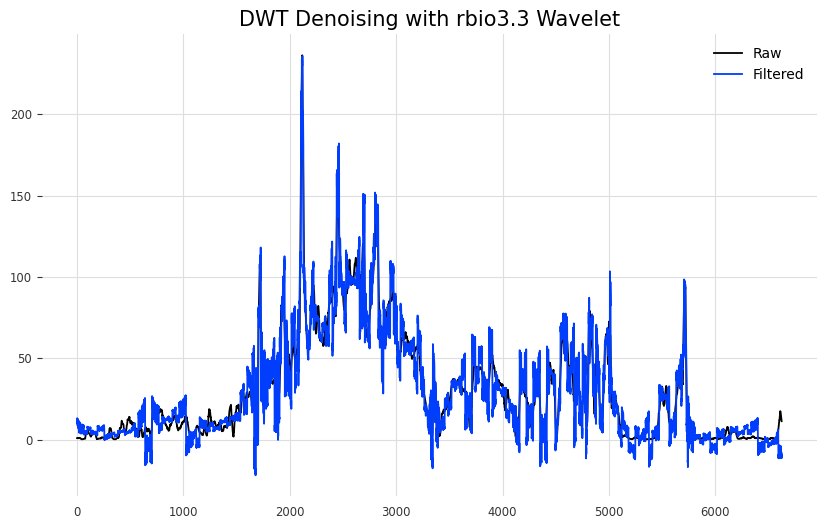

SNR: 9.353777861136924 dB
(6624,)
(6624,)


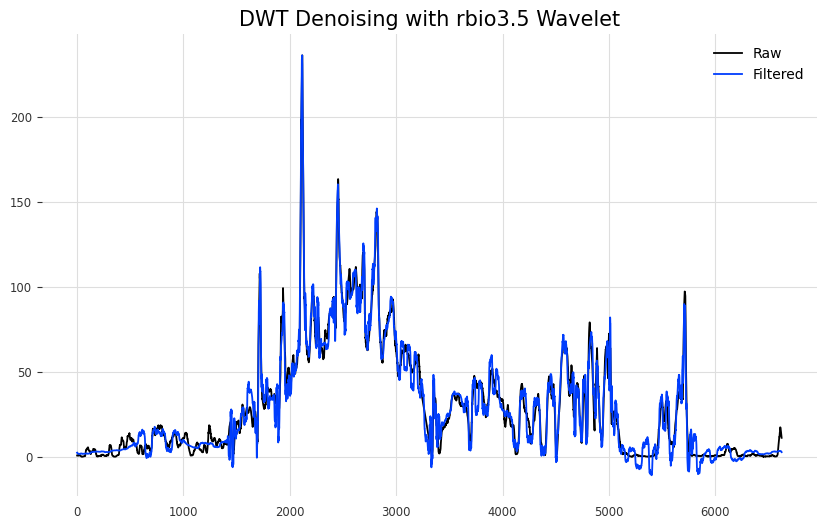

SNR: 13.862205952134634 dB
(6624,)
(6624,)


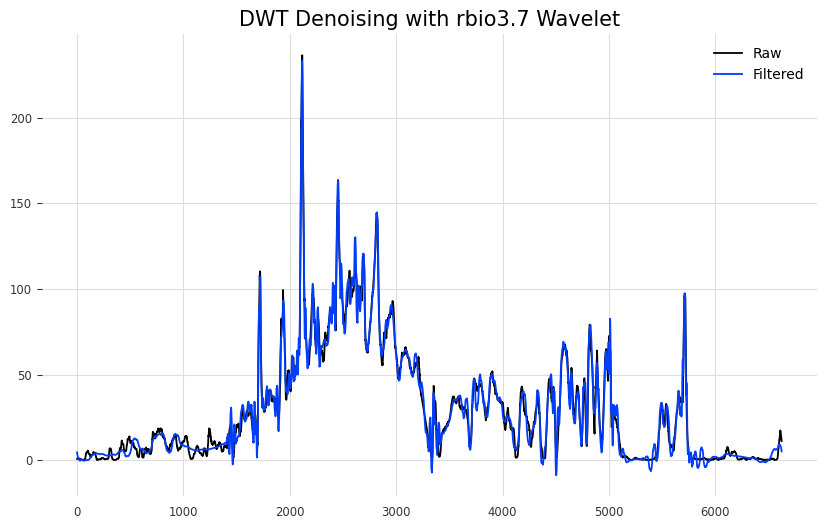

SNR: 15.918638326774994 dB
(6624,)
(6624,)


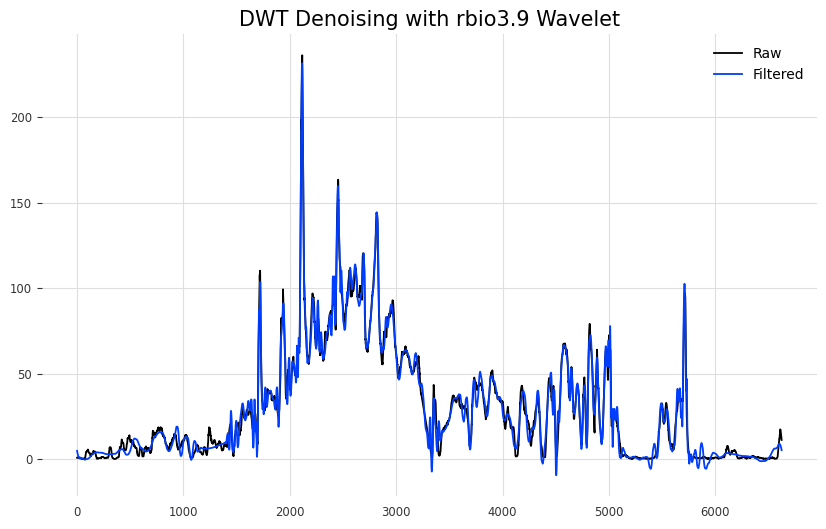

SNR: 16.582446081180645 dB
(6624,)
(6624,)


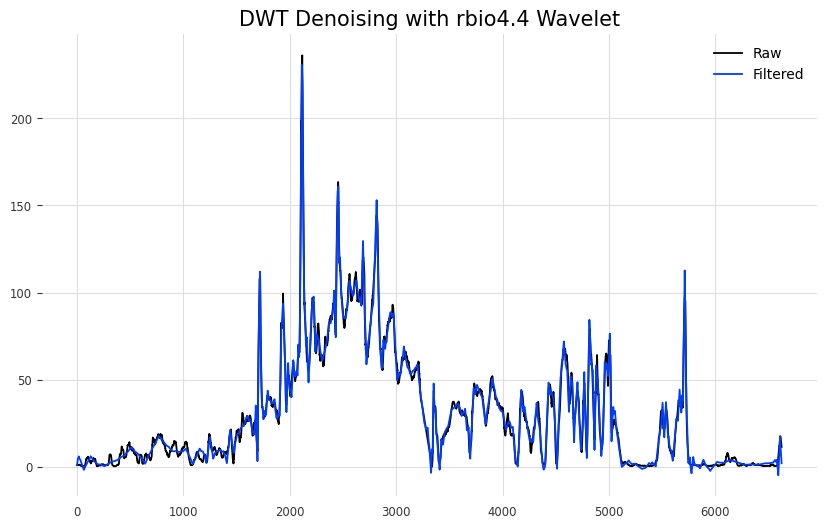

SNR: 20.01182764734316 dB
(6624,)
(6624,)


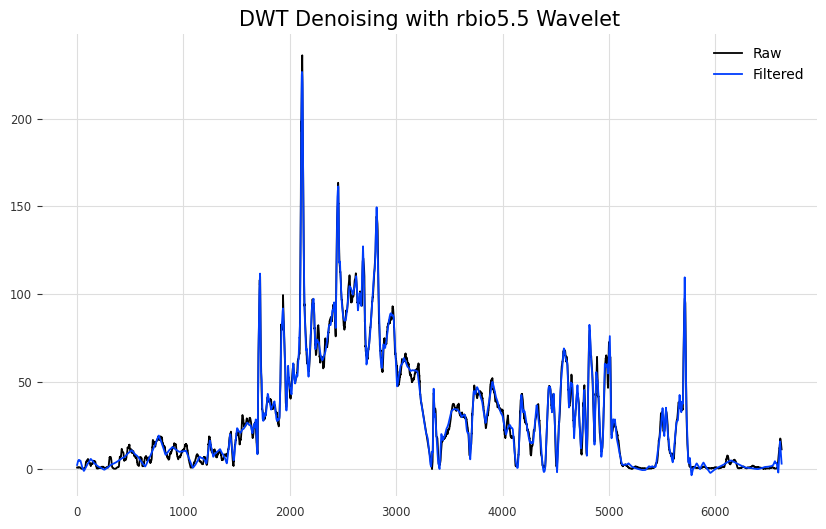

SNR: 20.852381070530626 dB
(6624,)
(6624,)


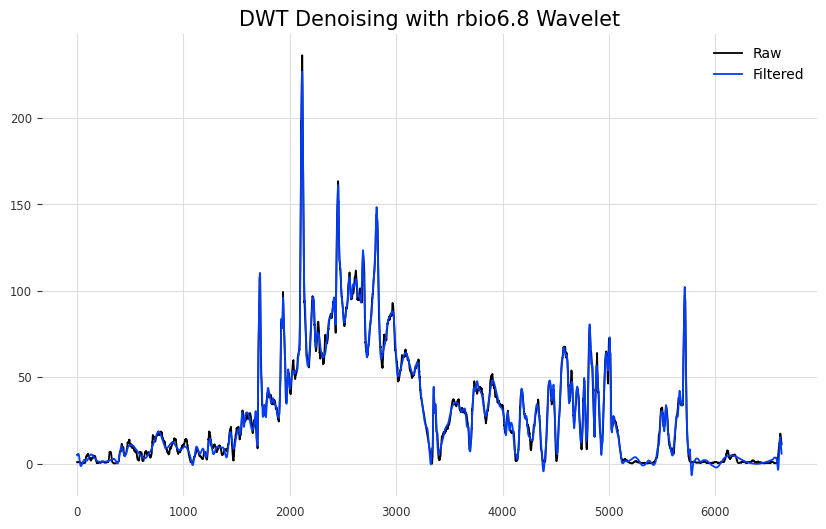

SNR: 21.57677866576318 dB
(6624,)
(6624,)


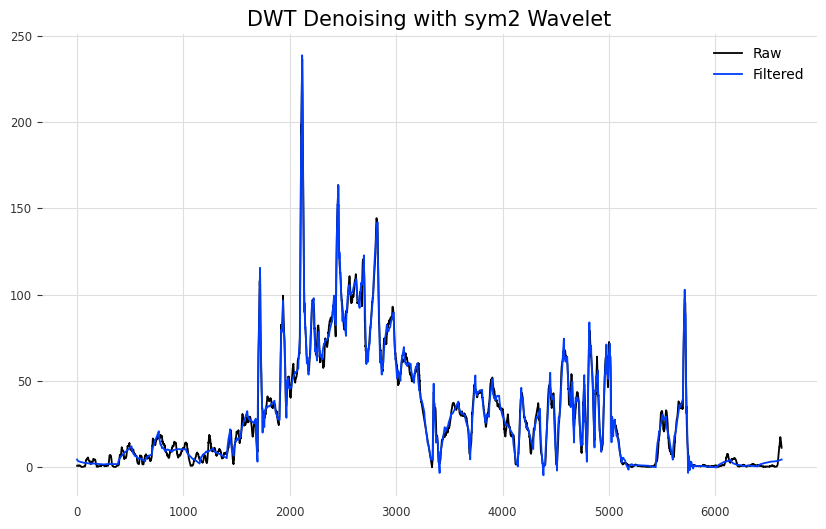

SNR: 19.431162897882565 dB
(6624,)
(6624,)


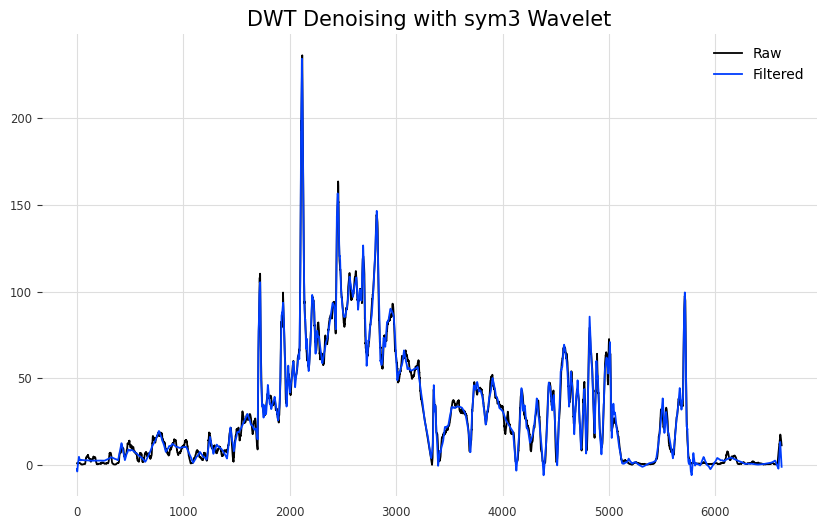

SNR: 20.273906217769742 dB
(6624,)
(6624,)


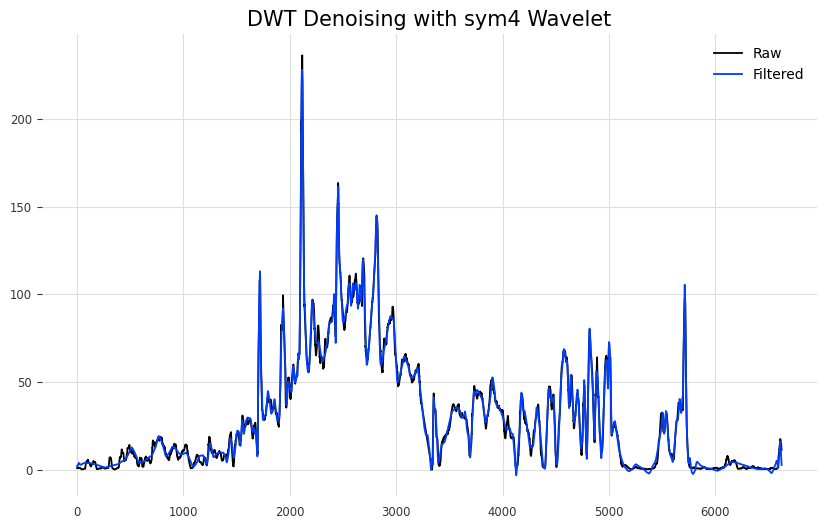

SNR: 21.022917389461607 dB
(6624,)
(6624,)


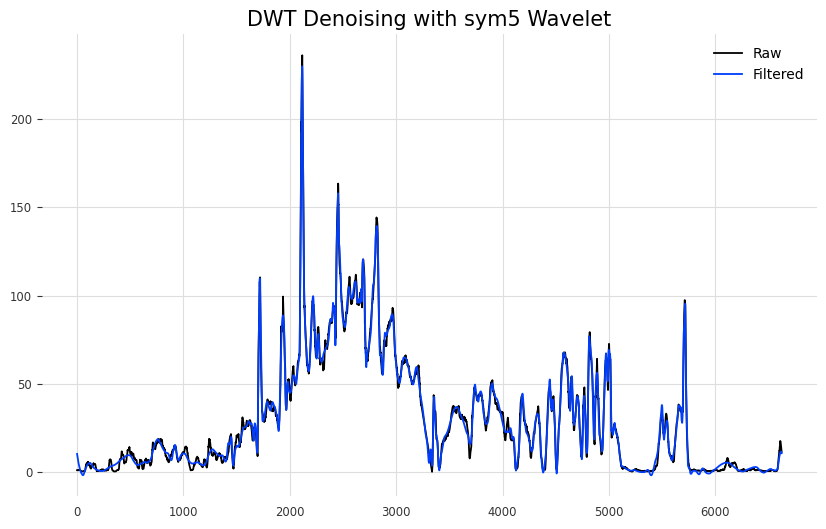

SNR: 21.400932049744835 dB
(6624,)
(6624,)


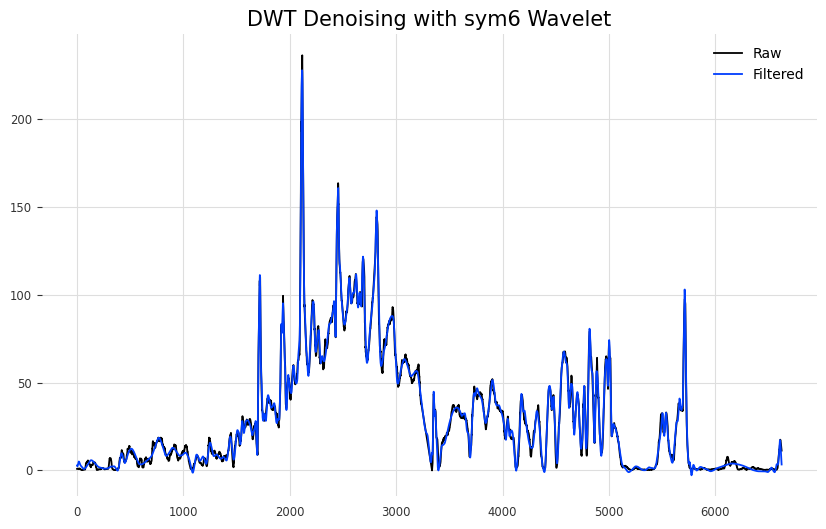

SNR: 22.381485418850215 dB
(6624,)
(6624,)


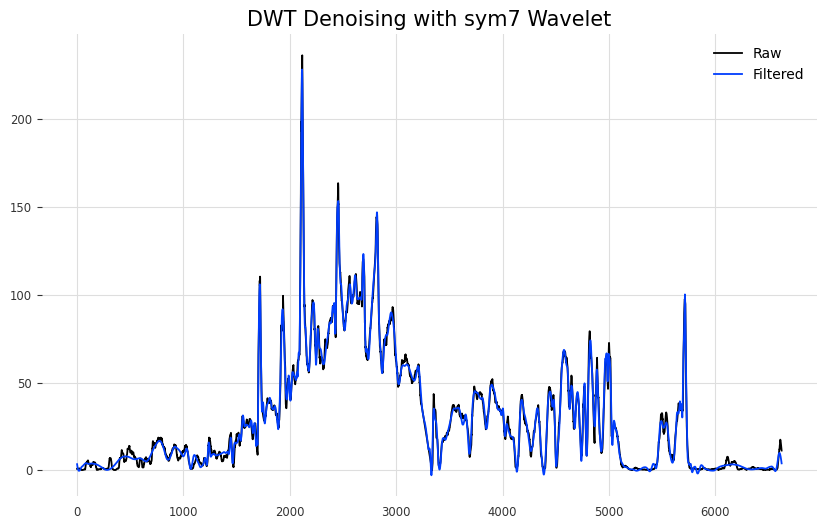

SNR: 21.397675370075913 dB
(6624,)
(6624,)


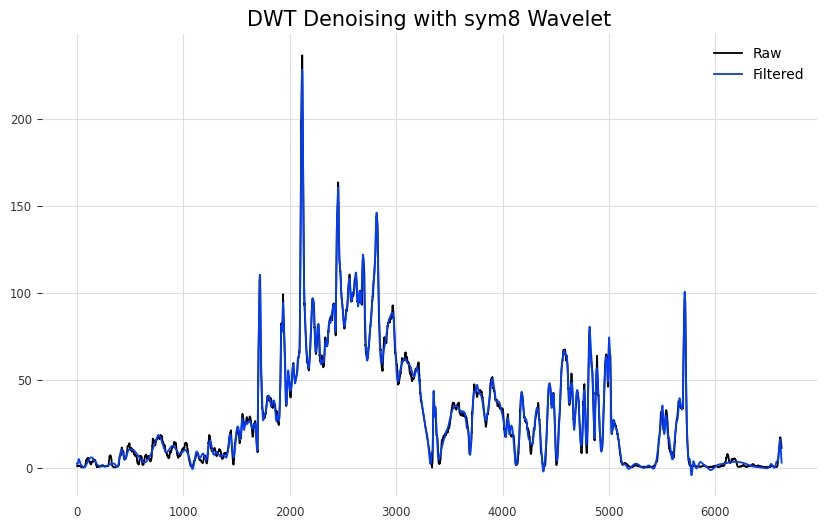

SNR: 22.76984943143478 dB
(6624,)
(6624,)


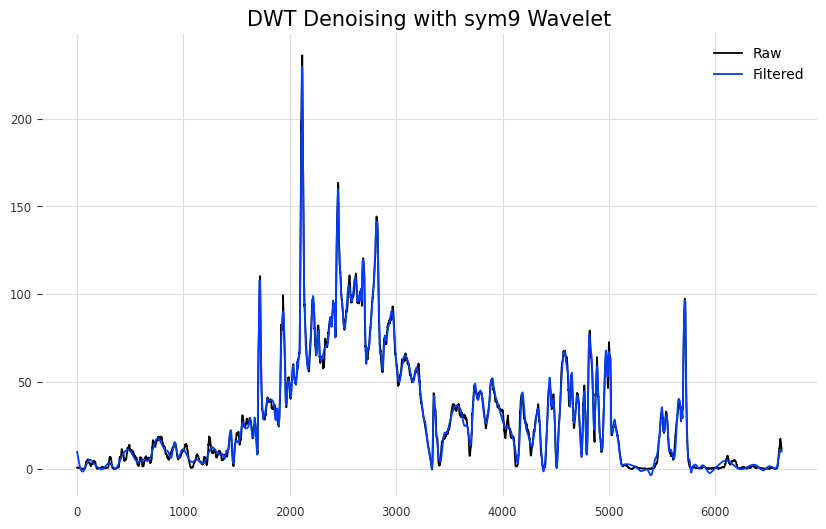

SNR: 21.963427660522772 dB
(6624,)
(6624,)


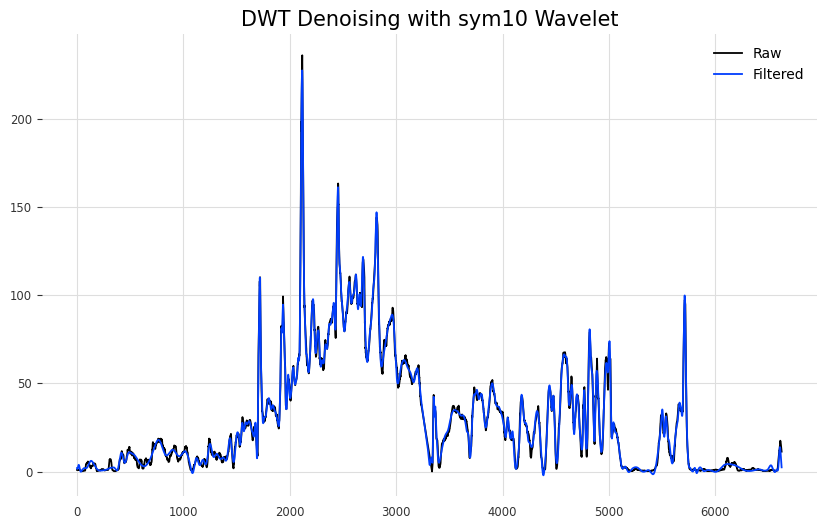

SNR: 23.167552317478943 dB
(6624,)
(6624,)


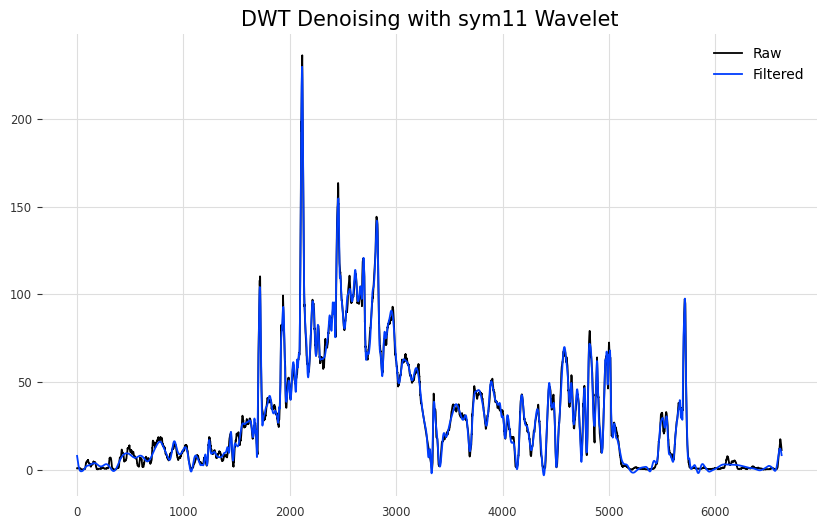

SNR: 21.789465855699298 dB
(6624,)
(6624,)


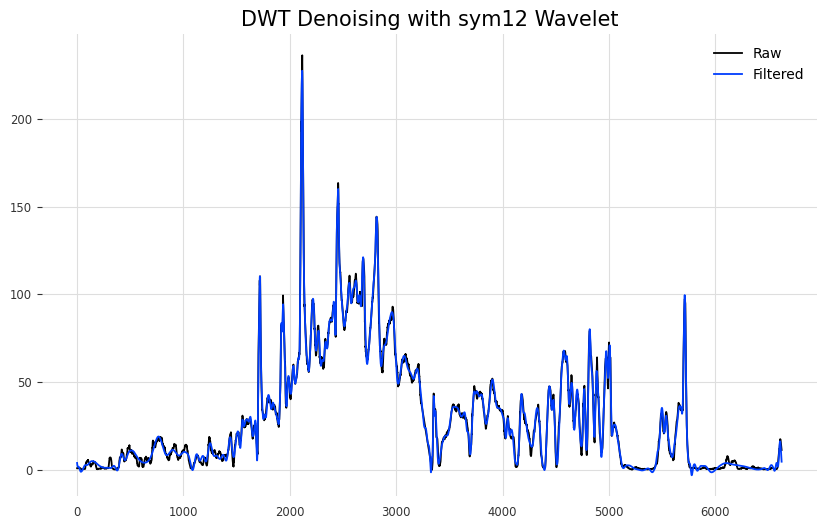

SNR: 23.299473943621752 dB
(6624,)
(6624,)


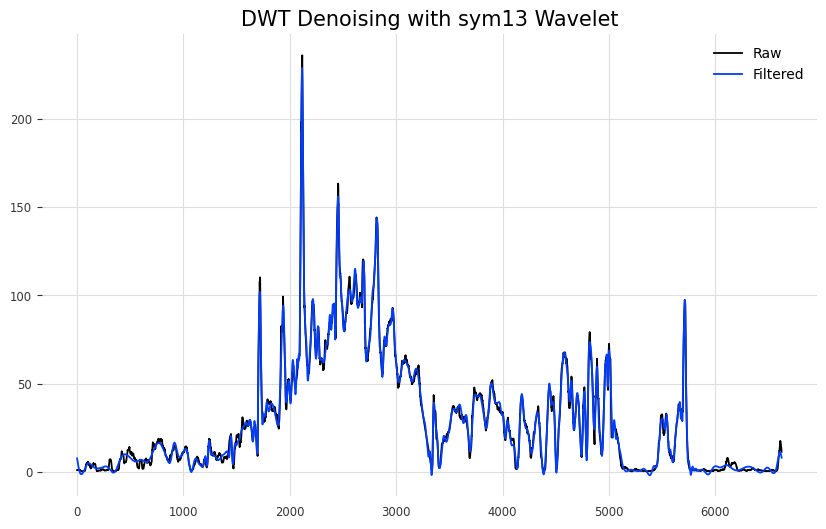

SNR: 21.947018134919283 dB
(6624,)
(6624,)


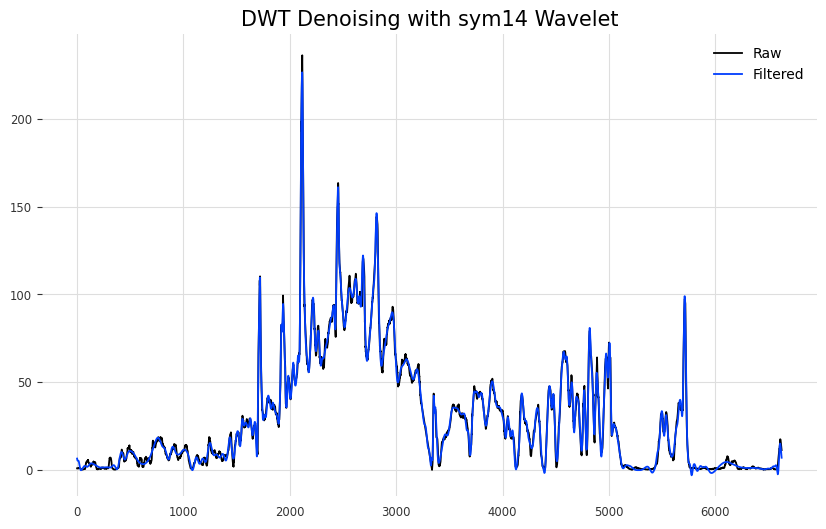

SNR: 23.292028257906324 dB
(6624,)
(6624,)


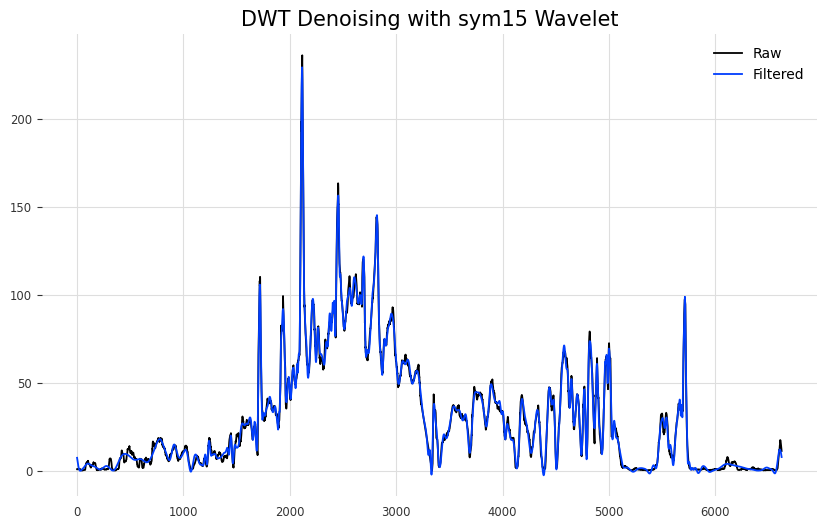

SNR: 22.35835364689549 dB
(6624,)
(6624,)


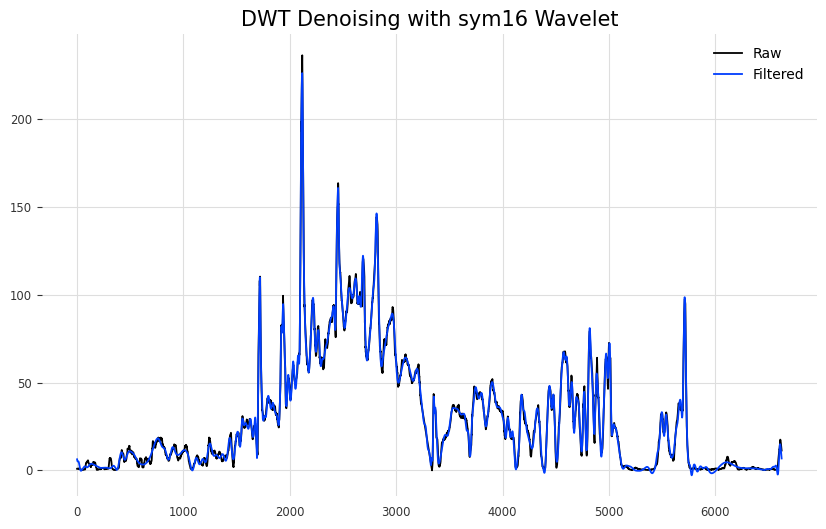

SNR: 23.222985960529677 dB
(6624,)
(6624,)


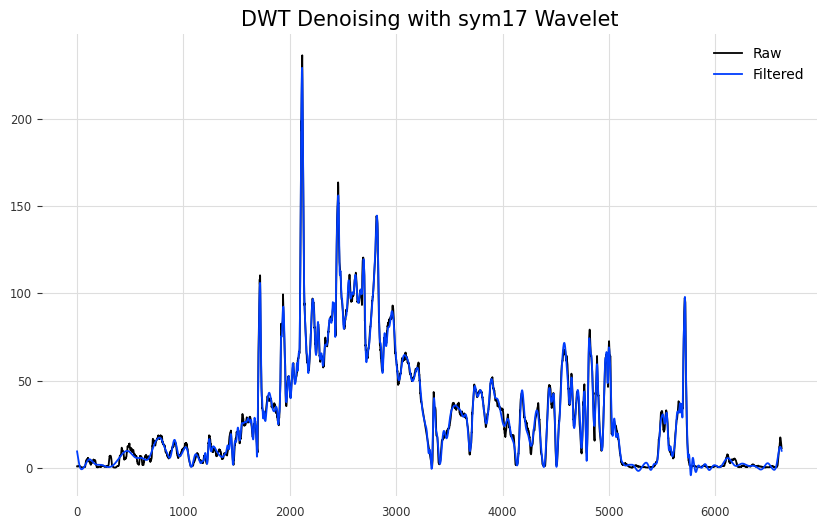

SNR: 22.450366799002374 dB
(6624,)
(6624,)


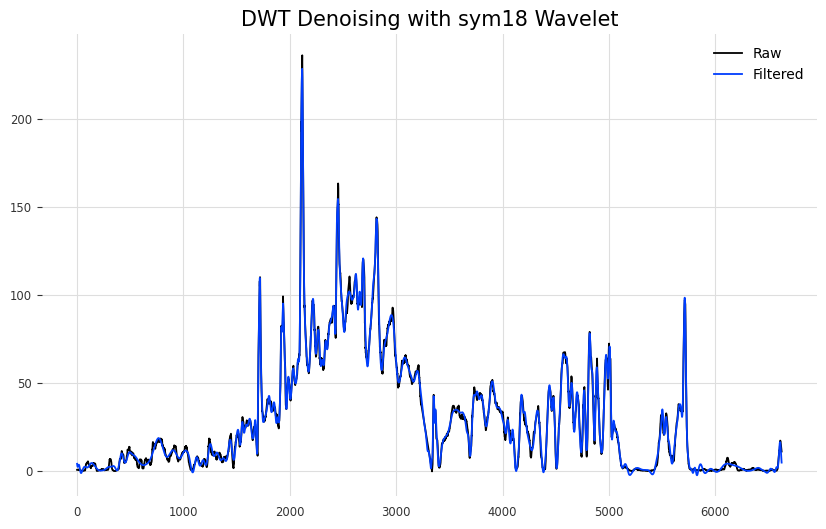

SNR: 23.297196120760326 dB
(6624,)
(6624,)


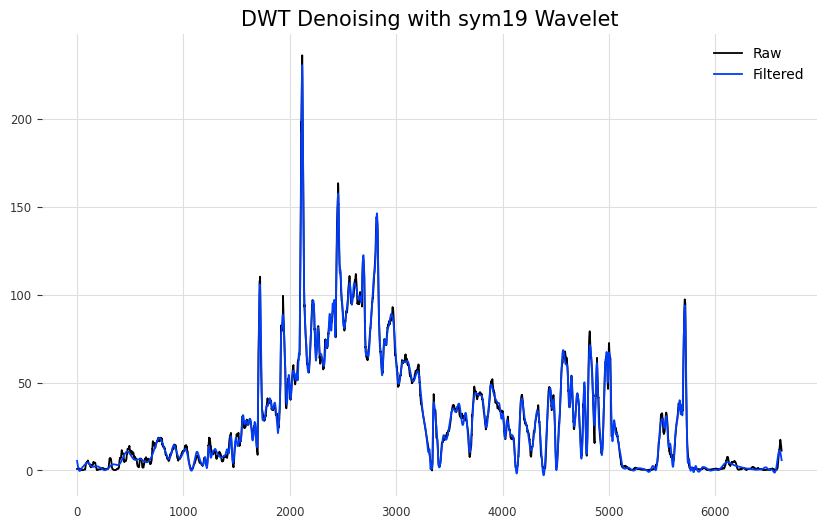

SNR: 22.473554214621384 dB
(6624,)
(6624,)


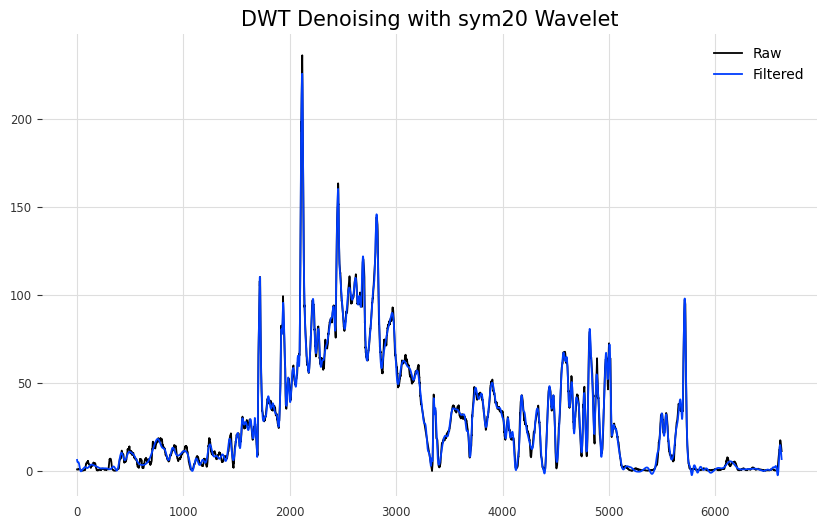

SNR: 23.194627934177593 dB
24.159933794637563 value and wavelet name: coif17


In [218]:
signal = df_radon_1
highest_snr = -np.inf
wavelet_name = 'lala'
for wav in pywt.wavelist():
    try:
        filtered = wavelet_denoising(signal, wavelet=wav, level=4)
        print(filtered.shape)
        print(signal.shape)
    except:
        continue
    
    plt.figure(figsize=(10, 6))
    plt.plot(signal, label='Raw')
    plt.plot(filtered, label='Filtered')
    plt.legend()
    plt.title(f"DWT Denoising with {wav} Wavelet", size=15)
    plt.show()
    mse = np.mean((filtered - signal) ** 2)
    snr = 10 * np.log10(np.var(signal) / mse)
    print(f"SNR: {snr} dB")
    if snr > highest_snr:
        highest_snr = snr
        wavelet_name = wav
print(f"{highest_snr} value and wavelet name: {wavelet_name}")

In [228]:
wavlet_dict = {}
string_wave = '''dmey
coif15
coif17
coif6
sym16
sym17
coif17
coif12
coif14
coif9
coif17
coif13
db34
coif9
sym15
coif10
coif16
sym9
bior3.3
coif9
coif17
coif10
coif7
sym19
coif17
coif9
coif9
coif15
coif13
coif11
sym17
coif12
coif10
coif13
coif9
coif17
coif16
coif12
coif10
'''
wavlets = string_wave.split('\n')
for i in range(len(df_radon.keys())):
    wavlet_dict[list(df_radon.keys())[i]] = wavlets[i]

In [229]:
wavlet_dict

{'1': 'dmey',
 '2': 'coif15',
 '3': 'coif17',
 '4': 'coif6',
 '5': 'sym16',
 '7': 'sym17',
 '8': 'coif17',
 '9': 'coif12',
 '10': 'coif14',
 '11': 'coif9',
 '13': 'coif17',
 '15': 'coif13',
 '16': 'db34',
 '17': 'coif9',
 '18': 'sym15',
 '19': 'coif10',
 '20': 'coif16',
 '21': 'sym9',
 '22': 'bior3.3',
 '23': 'coif9',
 '25': 'coif17',
 '26': 'coif10',
 '27': 'coif7',
 '28': 'sym19',
 '29': 'coif17',
 '30': 'coif9',
 '31': 'coif9',
 '32': 'coif15',
 '35': 'coif13',
 '36': 'coif11',
 '37': 'sym17',
 '39': 'coif12',
 '41': 'coif10',
 '43': 'coif13',
 '45': 'coif9',
 '46': 'coif17',
 '48': 'coif16',
 '49': 'coif12',
 '50': 'coif10'}

In [230]:
 for key in df_radon:
    df_radon[key]['Filtered Radon'] = wavelet_denoising(df_radon[key]['Radon'], wavelet=wavlet_dict[key], level=4)

In [231]:
df_radon['1']

Radon     eC02    VOC  Temperature  AirPressure  \
SyncDate                                                               
2022-05-11 18:00:00   2.20 1,612.00 427.00        89.00        30.07   
2022-05-11 19:00:00   2.20 1,796.00 447.00        90.00        30.06   
2022-05-11 20:00:00   2.20 1,643.00 284.00        88.00        30.05   
2022-05-11 21:00:00   2.30 1,524.00 190.00        86.00        30.05   
2022-05-11 22:00:00   2.30 1,337.00 142.00        84.00        30.06   
...                    ...      ...    ...          ...          ...   
2023-02-11 13:00:00   1.40   451.00   7.00        65.00        30.14   
2023-02-11 14:00:00   1.50   425.00   3.00        64.00        30.11   
2023-02-11 15:00:00   1.60   436.00   5.00        64.00        30.06   
2023-02-11 16:00:00   1.70   432.00   4.00        63.00        30.07   
2023-02-11 17:00:00   1.80   509.00  16.00        58.00        30.04   

                     Humidity  LogIndex  Filtered Radon  
SyncDate                                                 
2022-05-11 18:00:00     43.00    674.00            1.25  
2022-05-11 19:00:00     42.00    675.00            1.42  
2022-05-11 20:00:00     45.00    676.00            1.60  
2022-05-11 21:00:00     47.00    677.00            1.79  
2022-05-11 22:00:00     50.00    678.00            1.98  
...                       ...       ...             ...  
2023-02-11 13:00:00     42.00  7,172.00            0.65  
2023-02-11 14:00:00     48.00  7,173.00            0.74  
2023-02-11 15:00:00     47.00  7,174.00            0.86  
2023-02-11 16:00:00     50.00  7,175.00            0.98  
2023-02-11 17:00:00     59.00  7,176.00            1.11  

[6624 rows x 8 columns]

In [254]:
df_radon_filtered = pd.DataFrame(index=df_radon['1'].index)

In [255]:
for key in df_radon:
    df_radon_filtered[f"Radon_{key}"] = df_radon[key]['Filtered Radon']

In [256]:
df_radon_filtered

Radon_1  Radon_2  Radon_3  Radon_4  Radon_5  Radon_7  \
SyncDate                                                                    
2022-05-11 18:00:00     1.25     0.49     0.64     4.01    13.49     0.39   
2022-05-11 19:00:00     1.42     0.47     0.64     3.74    13.41     0.39   
2022-05-11 20:00:00     1.60     0.45     0.64     3.49    13.33     0.38   
2022-05-11 21:00:00     1.79     0.44     0.65     3.25    13.24     0.38   
2022-05-11 22:00:00     1.98     0.43     0.65     3.02    13.16     0.38   
...                      ...      ...      ...      ...      ...      ...   
2023-02-11 13:00:00     0.65     0.68     0.61     5.48    13.78     0.41   
2023-02-11 14:00:00     0.74     0.63     0.62     5.17    13.74     0.41   
2023-02-11 15:00:00     0.86     0.59     0.62     4.87    13.69     0.40   
2023-02-11 16:00:00     0.98     0.55     0.63     4.57    13.63     0.40   
2023-02-11 17:00:00     1.11     0.52     0.63     4.28    13.56     0.40   

                     Radon_8  Radon_9  Radon_10  Radon_11  ...  Radon_36  \
SyncDate                                                   ...             
2022-05-11 18:00:00     3.75    14.65      0.94     12.49  ...     10.07   
2022-05-11 19:00:00     3.83    15.06      0.98     12.05  ...     10.28   
2022-05-11 20:00:00     3.90    15.45      1.02     11.60  ...     10.47   
2022-05-11 21:00:00     3.95    15.80      1.06     11.16  ...     10.65   
2022-05-11 22:00:00     4.00    16.14      1.09     10.71  ...     10.81   
...                      ...      ...       ...       ...  ...       ...   
2023-02-11 13:00:00     3.27    12.38      0.70     14.60  ...      8.89   
2023-02-11 14:00:00     3.38    12.86      0.75     14.20  ...      9.14   
2023-02-11 15:00:00     3.48    13.33      0.80     13.78  ...      9.39   
2023-02-11 16:00:00     3.58    13.78      0.85     13.36  ...      9.63   
2023-02-11 17:00:00     3.67    14.23      0.89     12.93  ...      9.86   

                     Radon_37  Radon_39  Radon_41  Radon_43  Radon_45  \
SyncDate                                                                
2022-05-11 18:00:00      0.61      0.44      0.78      6.08      0.91   
2022-05-11 19:00:00      0.61      0.47      0.79      7.21      0.95   
2022-05-11 20:00:00      0.61      0.50      0.81      8.18      1.00   
2022-05-11 21:00:00      0.61      0.53      0.82      8.92      1.06   
2022-05-11 22:00:00      0.61      0.56      0.83      9.36      1.12   
...                       ...       ...       ...       ...       ...   
2023-02-11 13:00:00      0.62      0.29      0.69      1.24      0.78   
2023-02-11 14:00:00      0.62      0.31      0.71      1.85      0.80   
2023-02-11 15:00:00      0.62      0.34      0.73      2.70      0.82   
2023-02-11 16:00:00      0.62      0.37      0.75      3.73      0.84   
2023-02-11 17:00:00      0.62      0.41      0.76      4.89      0.87   

                     Radon_46  Radon_48  Radon_49  Radon_50  
SyncDate                                                     
2022-05-11 18:00:00      7.95     24.28      0.65     11.11  
2022-05-11 19:00:00      7.44     23.71      0.64     10.47  
2022-05-11 20:00:00      6.92     23.16      0.63      9.94  
2022-05-11 21:00:00      6.39     22.63      0.62      9.53  
2022-05-11 22:00:00      5.86     22.14      0.60      9.28  
...                       ...       ...       ...       ...  
2023-02-11 13:00:00     10.27     27.24      0.71     14.86  
2023-02-11 14:00:00      9.85     26.67      0.70     14.12  
2023-02-11 15:00:00      9.41     26.08      0.69     13.35  
2023-02-11 16:00:00      8.94     25.48      0.68     12.57  
2023-02-11 17:00:00      8.45     24.87      0.67     11.82  

[6624 rows x 39 columns]